**Introduction:**

Peer-to-peer (P2P) lending represents an innovative method of peer-to-peer money lending, facilitated through online platforms. This study employs real-world data obtained from "Lending Club," an American-based company, to predict credit solvency(Binary Classification) using various predictive models and techniques, including Lasso, Ridge, Elastic-Net, Logistic Regression, Extreme Gradient Boosting, and Bayesian Additive Regression Trees (BART). Through an economic evaluation of the context and the results obtained from the models, this study aims to draw conclusions regarding credit risk assessment in the P2P lending market.

The original data set is large: 1.6 GB csv file. It was scraped from the Lending Club website by some guy on github.
We downloaded it from kaggle:
 https://www.kaggle.com/datasets/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150

In [2]:
path= "C:\\Users\\giuse\\OneDrive\\Desktop\\uni venezia\\terzo periodo\\models and technologies for the financial industry\\lending_club_large\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv"
df = pd.read_csv(path, low_memory = False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None


Before dropping the columns that contain information about loan payments, we calculate the average loss for a defaulted loan as a percentage of loan principal

In [3]:
((df.loan_amnt-df.total_pymnt)/df.loan_amnt)[df.loan_status.isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off'])].mean()

0.45876620898892995

On average loans that default pay back 54% of the principal

In [4]:
#selecting the variables of our interest
cols_to_keep = [
    "annual_inc","application_type","dti","earliest_cr_line","emp_length","fico_range_high","fico_range_low","grade",
    "home_ownership","inq_last_6mths","installment","int_rate","issue_d","loan_amnt","loan_status","mo_sin_rcnt_tl",
    "mort_acc","mths_since_recent_bc","disbursement_method","verification_status","term","tax_liens","sub_grade",
    "purpose","pub_rec_bankruptcies","percent_bc_gt_75","num_bc_tl","num_actv_rev_tl","num_actv_bc_tl","num_accts_ever_120_pd",
    "acc_now_delinq","acc_open_past_24mths","open_acc","pct_tl_nvr_dlq","pub_rec","total_acc","total_bal_ex_mort"
]

df = df[cols_to_keep]
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


Most of the columns we removed had NAs on a large portion of the dataset.
Also some columns already contained information on the loan default

The features we kept have information on the borrower's income, employment, previous credit history, on the loan interest, purpose, duration.

The loan_status variable is the target feature of our analysis

In [5]:
df.loan_status.value_counts()

loan_status
Fully Paid            953502
Current               803484
Charged Off           234903
Late (31-120 days)     19341
In Grace Period         7745
Late (16-30 days)       3853
Default                   33
Name: count, dtype: int64

We need to group it into two classes: default = 1 and default = 0

Also we will drop current loans, since at the time the data was scraped from Lending Club website it wasn't known if the loan defaulted or not.

In [6]:
df = df[df.loan_status != "Current"] #dropping current loans

default_categories = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
loan_status_dummy = df.loan_status.isin(default_categories).astype("uint8")
df.loan_status = loan_status_dummy

df.reset_index(inplace = True, drop = True)

## Variables' descriptions

In [7]:
pd.set_option("display.max_colwidth",300)
description =  pd.read_csv("description_col.csv",index_col="Nome_Variabile")
description

,Descrizione,Data_Type
Nome_Variabile,,
annual_inc,The combined self-reported annual income provided by the co-borrowers during registration,float64
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers,object
dti,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income",float64
earliest_cr_line,Earliest credit line at time of application for the secondary applicant,object
emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,object
fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.,float64
fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.,float64
grade,LC assigned loan grade,object
home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER",object


## Data visualisation


We will start with numeric, continuous variables

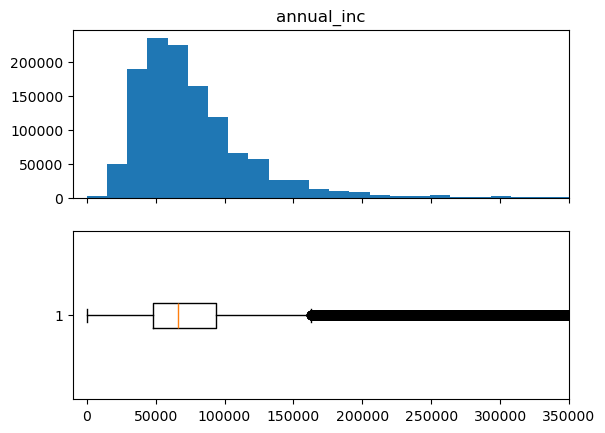

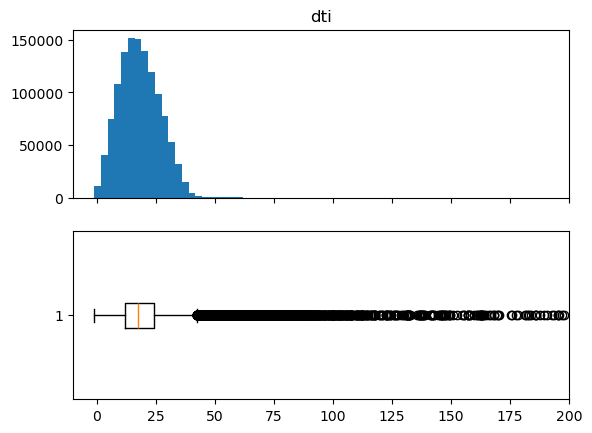

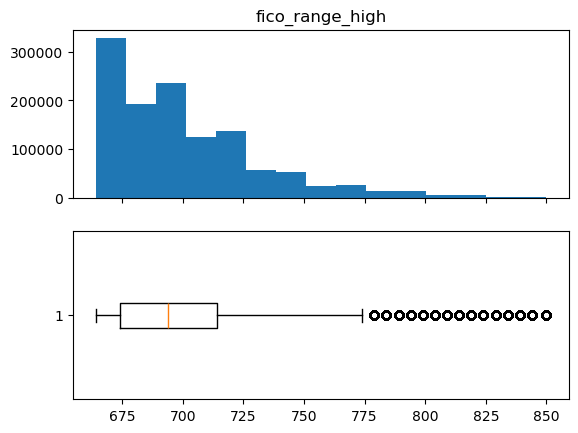

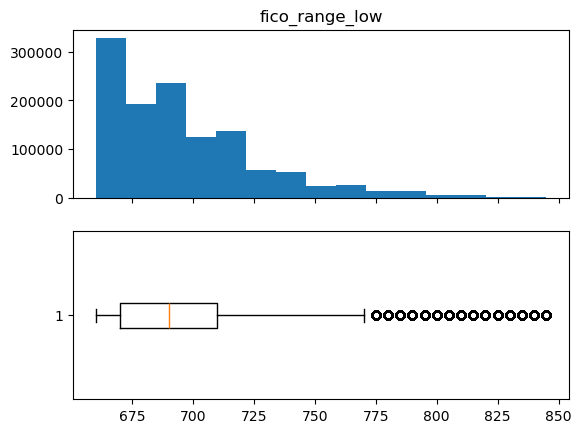

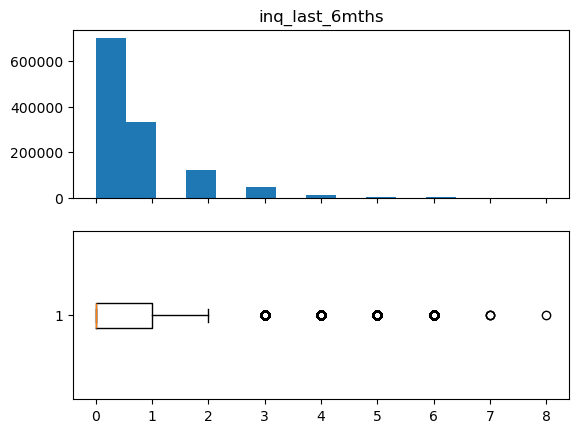

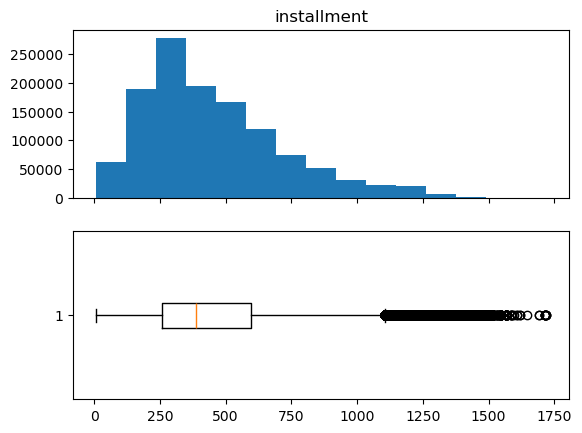

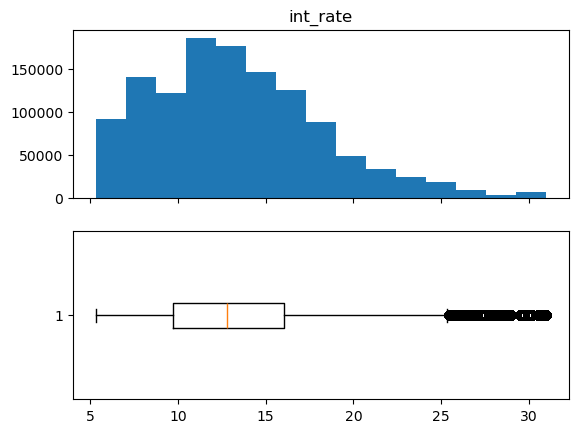

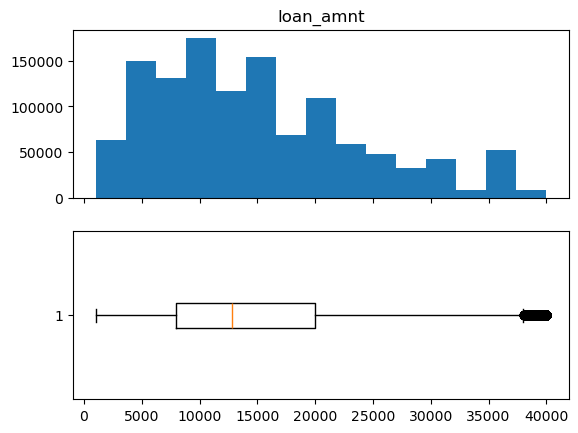

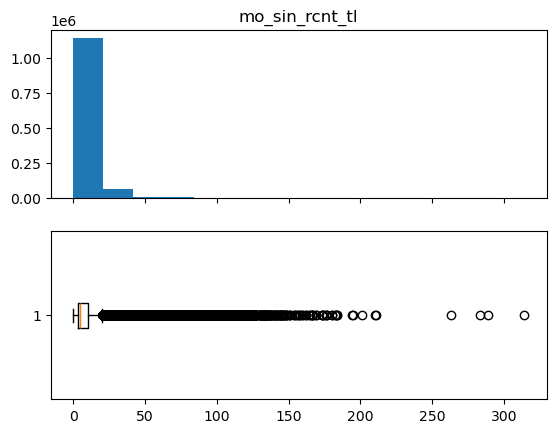

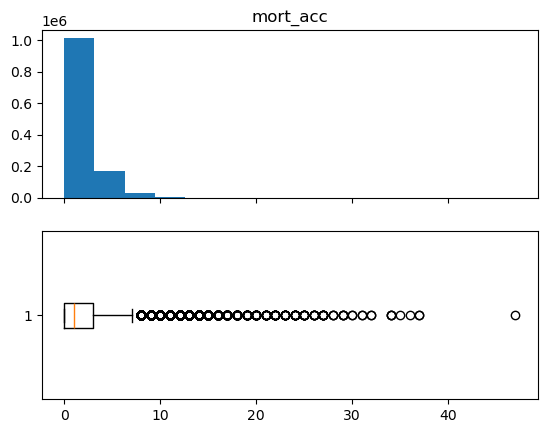

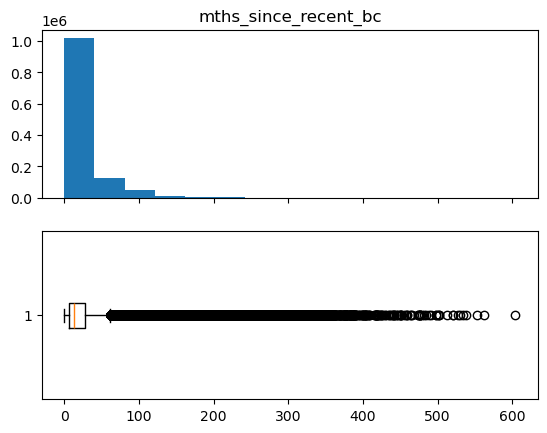

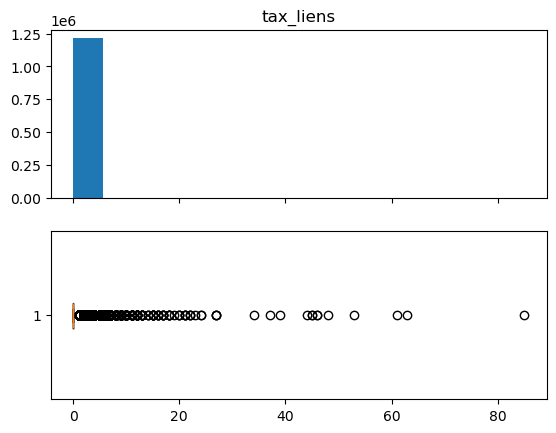

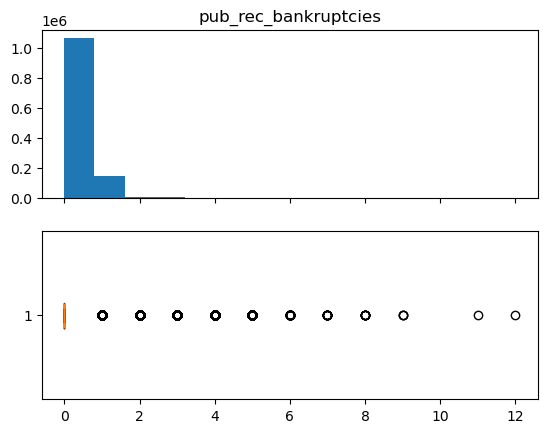

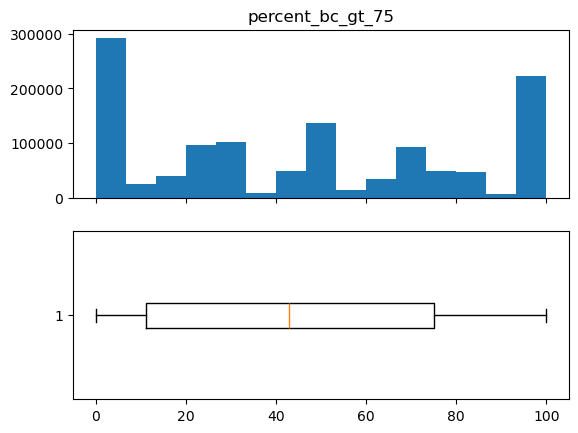

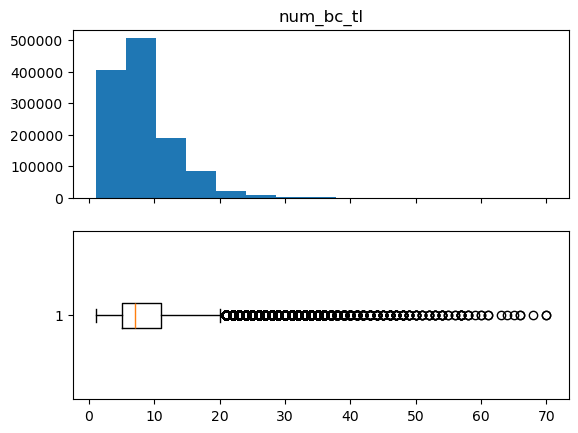

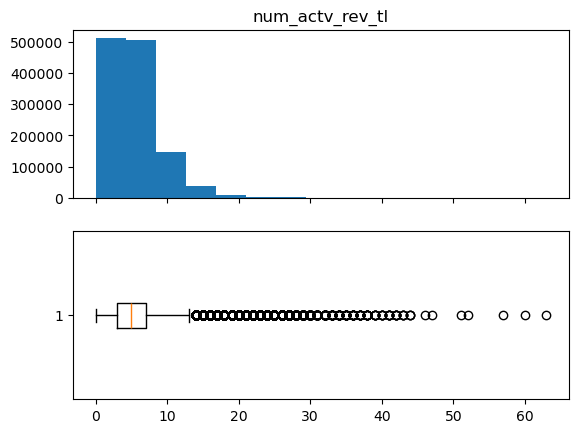

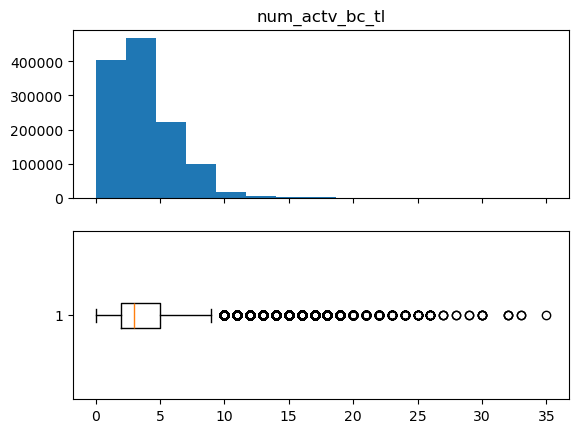

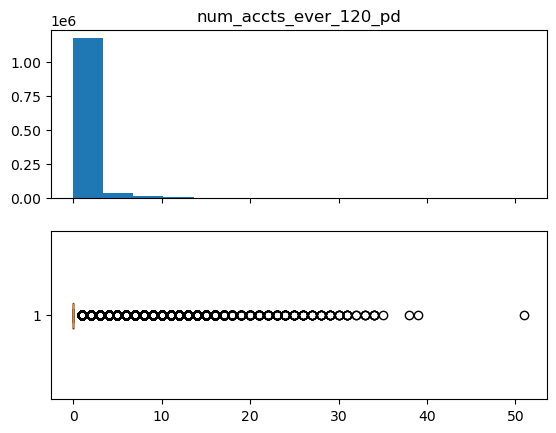

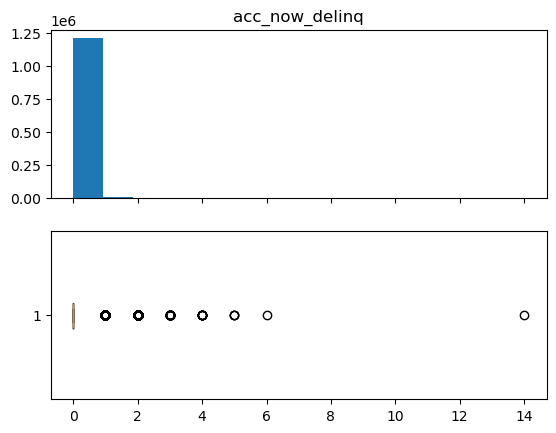

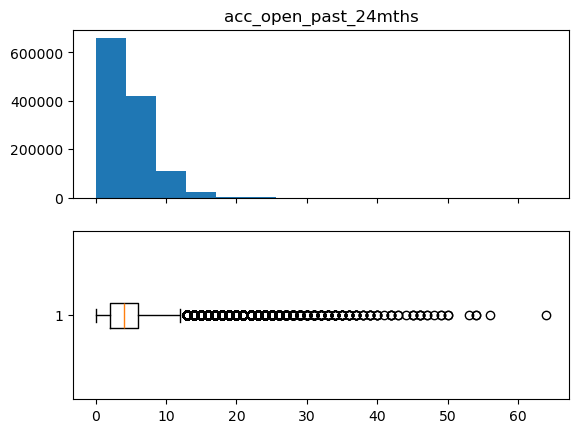

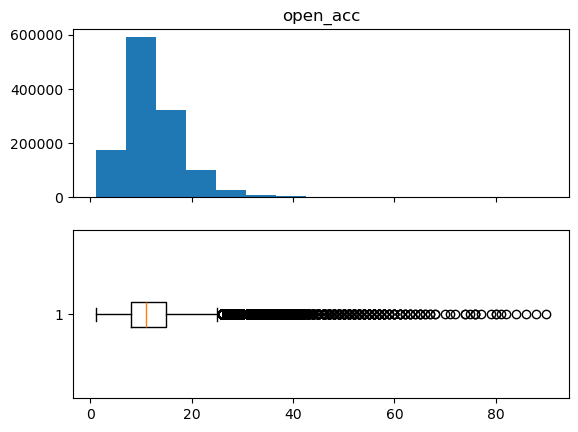

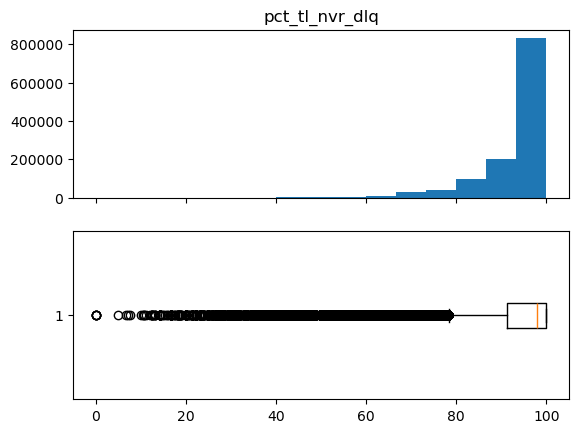

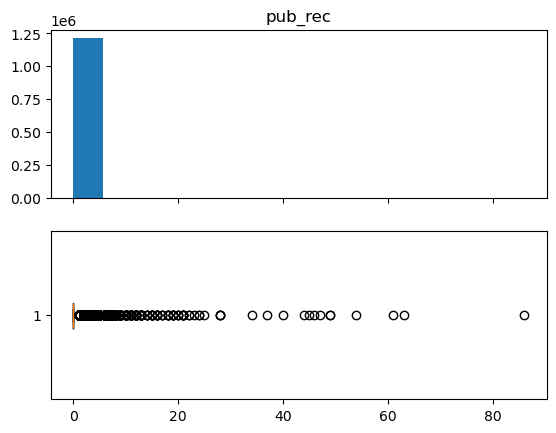

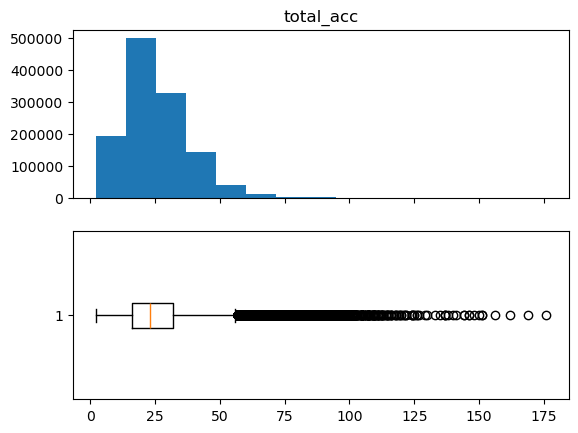

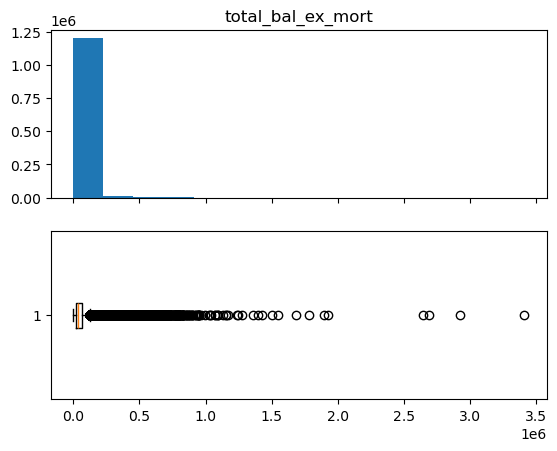

In [8]:
numeric_vars = df.columns[df.dtypes == "float64"]

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.hist(df["annual_inc"], bins = 750)
ax2.boxplot(df["annual_inc"], vert = False)
ax1.set_title("annual_inc")
ax1.set_xlim(-10000, 350000)
ax2.set_xlim(-10000, 350000)
plt.show()

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.hist(df["dti"], bins = 350)
ax2.boxplot(df["dti"], vert = False)
ax1.set_title("dti")
ax1.set_xlim(-10, 200)
ax2.set_xlim(-10, 200)
plt.show()

for var in numeric_vars:
    if var not in ["annual_inc","dti"]:
        fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
        ax1.hist(df[var], bins = 15)
        ax2.boxplot(df[var], vert = False)
        ax1.set_title(var)
        plt.show()

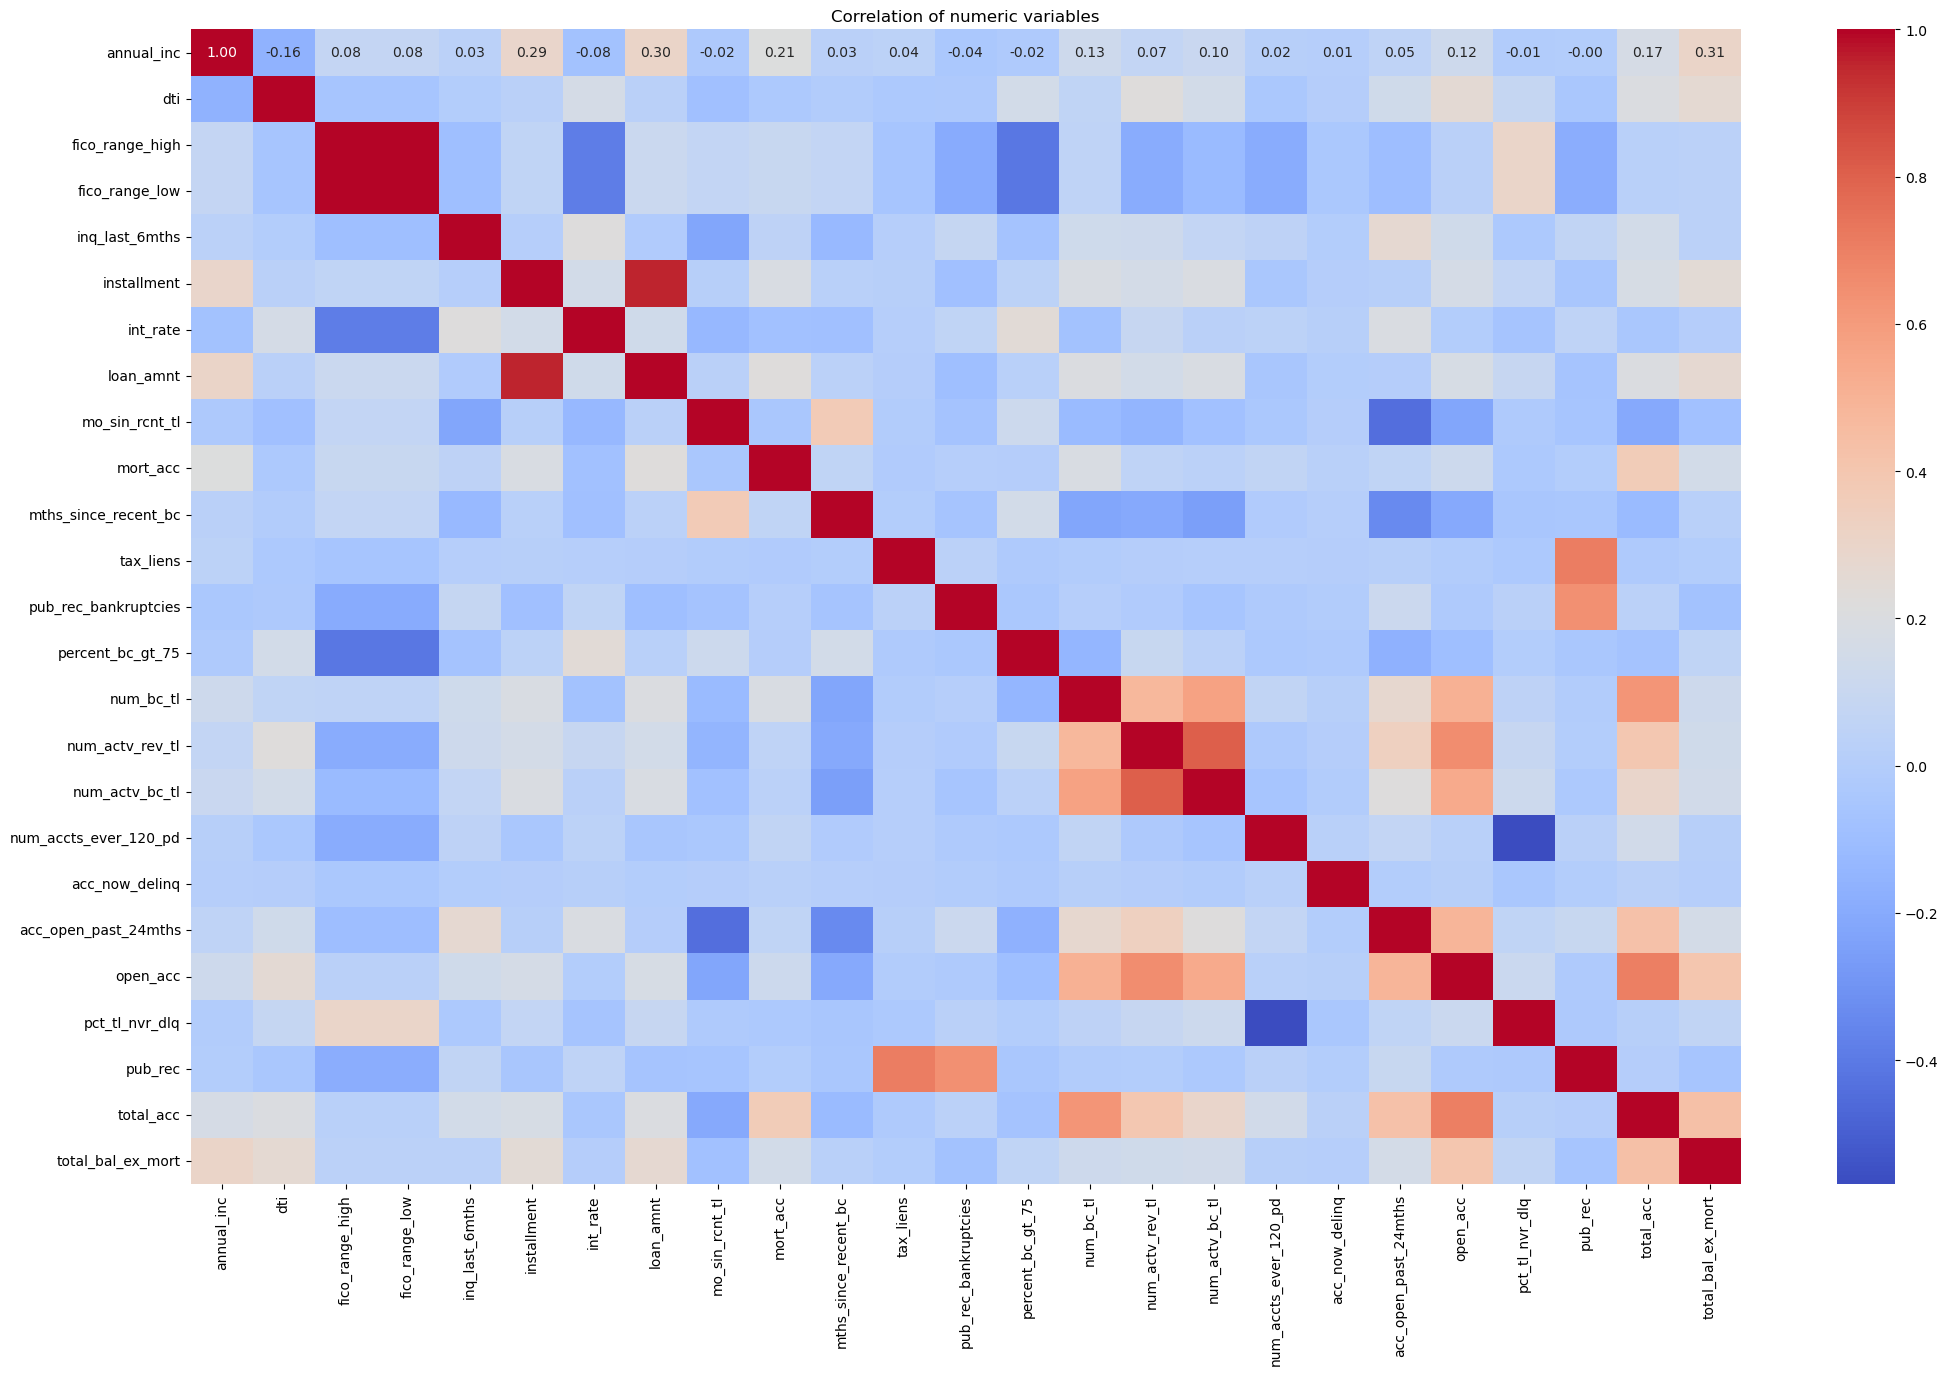

In [9]:
correlation_matrix = df[numeric_vars].corr()
plt.figure(figsize=(25,15))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation of numeric variables")
plt.show()

We can see that there are some variables that are highly correlated and just provide the same information: FICO range high and FICO range low; loan amount and installment. Regularization techinques will help dealing with this problem

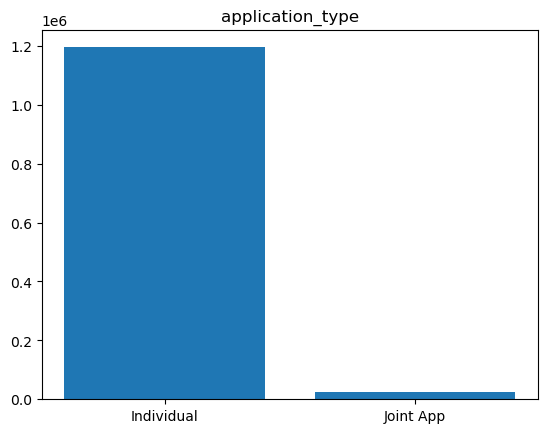

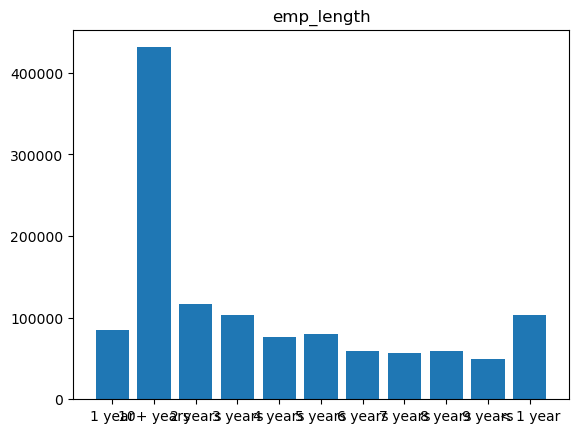

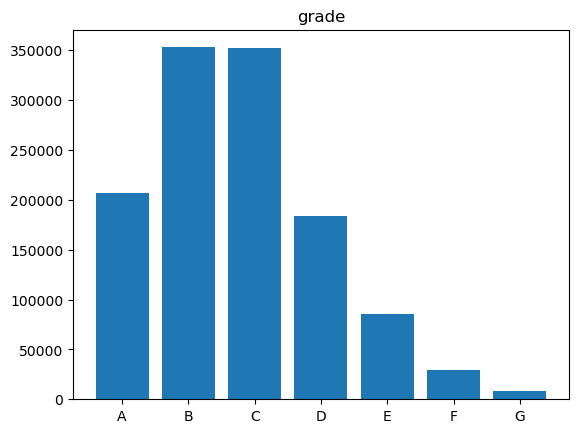

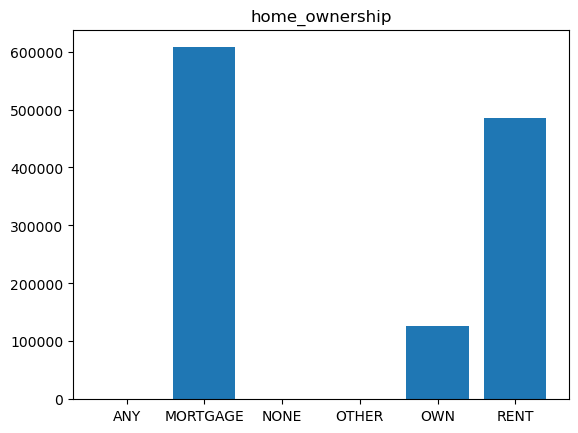

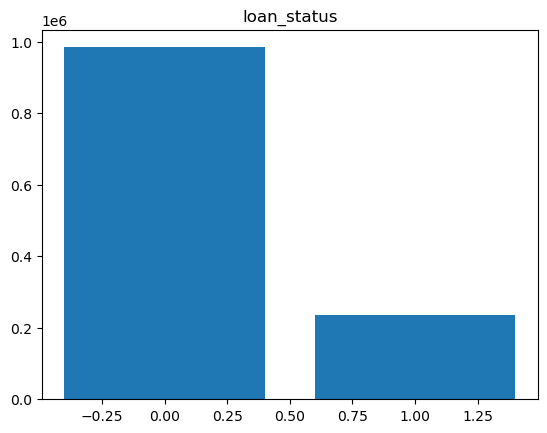

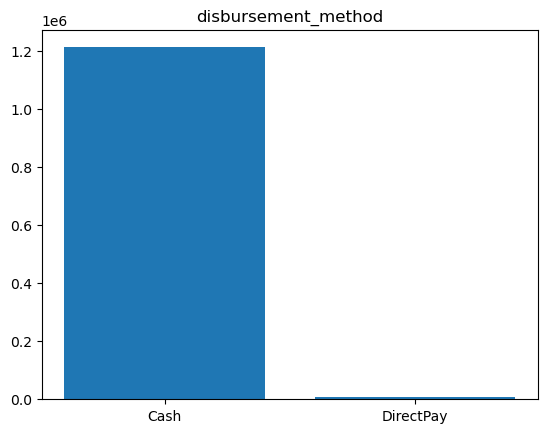

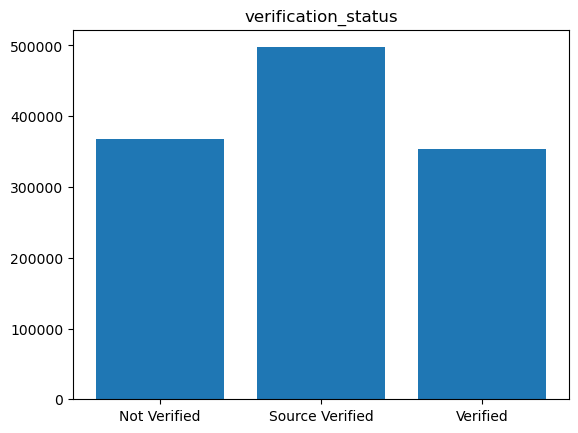

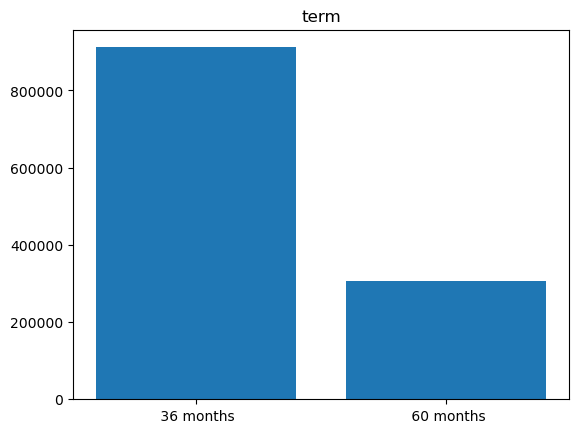

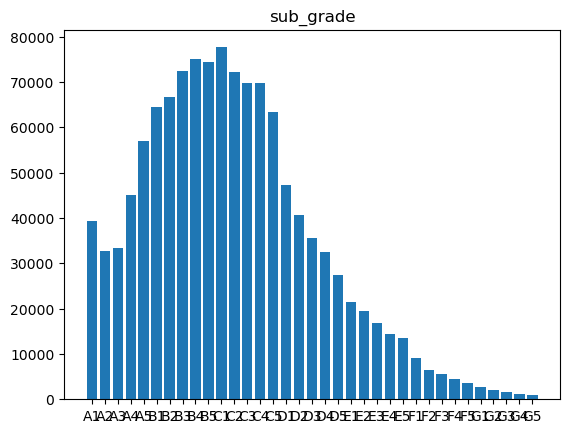

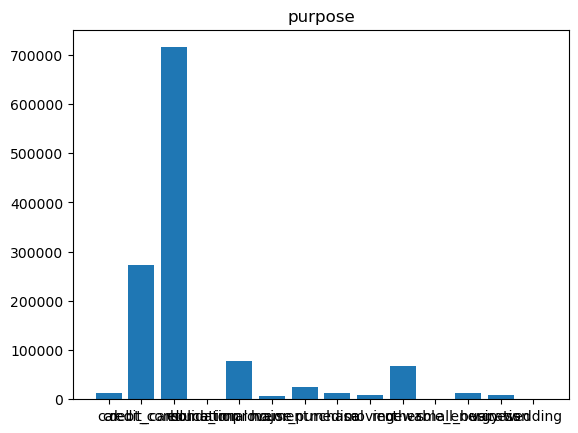

In [10]:
categorical_vars = df.columns[df.dtypes != "float64"]

for var in categorical_vars:
    if var not in ["earliest_cr_line", "issue_d"]:
        data = df[var].groupby(df[var]).count()
        plt.bar(x = data.index, height= data.to_numpy())
        plt.title(var)
        plt.show()

Again we see that some features contain the same information: Grade and Subgrade.

We will need to transform the categorical variables to numeric ones.


In [11]:
from sklearn.preprocessing import OrdinalEncoder

term_dummies = pd.get_dummies(df.term,prefix= "term")
df = pd.concat([df, term_dummies], axis = 1)
df.drop(columns = ["term",'term_ 36 months'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop 36 months since it is the highest frequency class

#subgrade
enc = OrdinalEncoder()
sub_grade_encoded = pd.Series(enc.fit_transform(df.sub_grade.array.reshape(-1,1)).flatten())
sub_grade_encoded = sub_grade_encoded*-1 # we invert the rating: highest grade has the highest number
df.sub_grade = sub_grade_encoded

#grade
enc = OrdinalEncoder()
grade_encoded = pd.Series(enc.fit_transform(df.grade.array.reshape(-1,1)).flatten())
grade_encoded = grade_encoded*-1 # we invert the rating: highest grade has the highest number
df.grade = grade_encoded

#home ownership
# we will first collapse some classes into one: any, none and other will be grouped together
df.home_ownership[df.home_ownership == "ANY"] = "OTHER"
df.home_ownership[df.home_ownership == "NONE"] = "OTHER"

home_ownership_dummies = pd.get_dummies(df.home_ownership,prefix= "home_ownership")
df = pd.concat([df, home_ownership_dummies], axis = 1)
df.drop(columns = ["home_ownership",'home_ownership_MORTGAGE'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop MORTGAGE since it is the highest frequency class

# verification status
verification_status_dummies = pd.get_dummies(df.verification_status,prefix= "verification_status")
df = pd.concat([df, verification_status_dummies], axis = 1)
df.drop(columns = ["verification_status",'verification_status_Source Verified'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop Source Verified since it is the highest frequency class

#purpose
# first we group educational with other because there is only one instance of it
df.purpose[df.purpose == "educational"] = "other"
purpose_dummies = pd.get_dummies(df.purpose,prefix= "purpose")
df = pd.concat([df, purpose_dummies], axis = 1)
df.drop(columns = ["purpose",'purpose_debt_consolidation'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop educational because there is only one value

#application_type
application_type_dummies = pd.get_dummies(df.application_type,prefix= "application_type")
df = pd.concat([df, application_type_dummies], axis = 1)
df.drop(columns = ["application_type",'application_type_Individual'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop application_type since it is the highest frequency class

# disbursement_method
disbursement_method_dummies = pd.get_dummies(df.disbursement_method,prefix= "disbursement_method")
df = pd.concat([df, disbursement_method_dummies], axis = 1)
df.drop(columns = ["disbursement_method",'disbursement_method_Cash'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop Cash since it is the highest frequency class

#emp_length
emp_length_map = {
    "1 year": 1,
    "10+ years":10,
    "2 years":2,
    "3 years":3,
    "4 years":4,
    "5 years":5,
    "6 years":6,
    "7 years":7,
    "8 years":8,
    "9 years":9,
    "< 1 year" : 0
}

df.emp_length = df.emp_length.map(emp_length_map)



C:\Users\giuse\AppData\Local\Temp\ipykernel_10060\934061891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.home_ownership[df.home_ownership == "ANY"] = "OTHER"
C:\Users\giuse\AppData\Local\Temp\ipykernel_10060\934061891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.home_ownership[df.home_ownership == "NONE"] = "OTHER"
C:\Users\giuse\AppData\Local\Temp\ipykernel_10060\934061891.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

We also have the variables Issue date and Earliest credit line that are a timestamp. We will encode it with an integer number, setting 0 for the earliest date and the highest number for the latest date

In [12]:
#earliest_credit_line
enc = OrdinalEncoder()
earliest_cr_line_encoded = pd.Series(enc.fit_transform(pd.to_datetime(df.earliest_cr_line, format = "%b-%Y").array.reshape(-1,1)).flatten())
df.earliest_cr_line = earliest_cr_line_encoded

#issue_date
enc = OrdinalEncoder()
issue_d_encoded = pd.Series(enc.fit_transform(pd.to_datetime(df.issue_d, format = "%b-%Y").array.reshape(-1,1)).flatten())
df.issue_d = issue_d_encoded

In [13]:
df.isna().sum().sum()

0

We now plot the variables' distributions according to class of target variable.

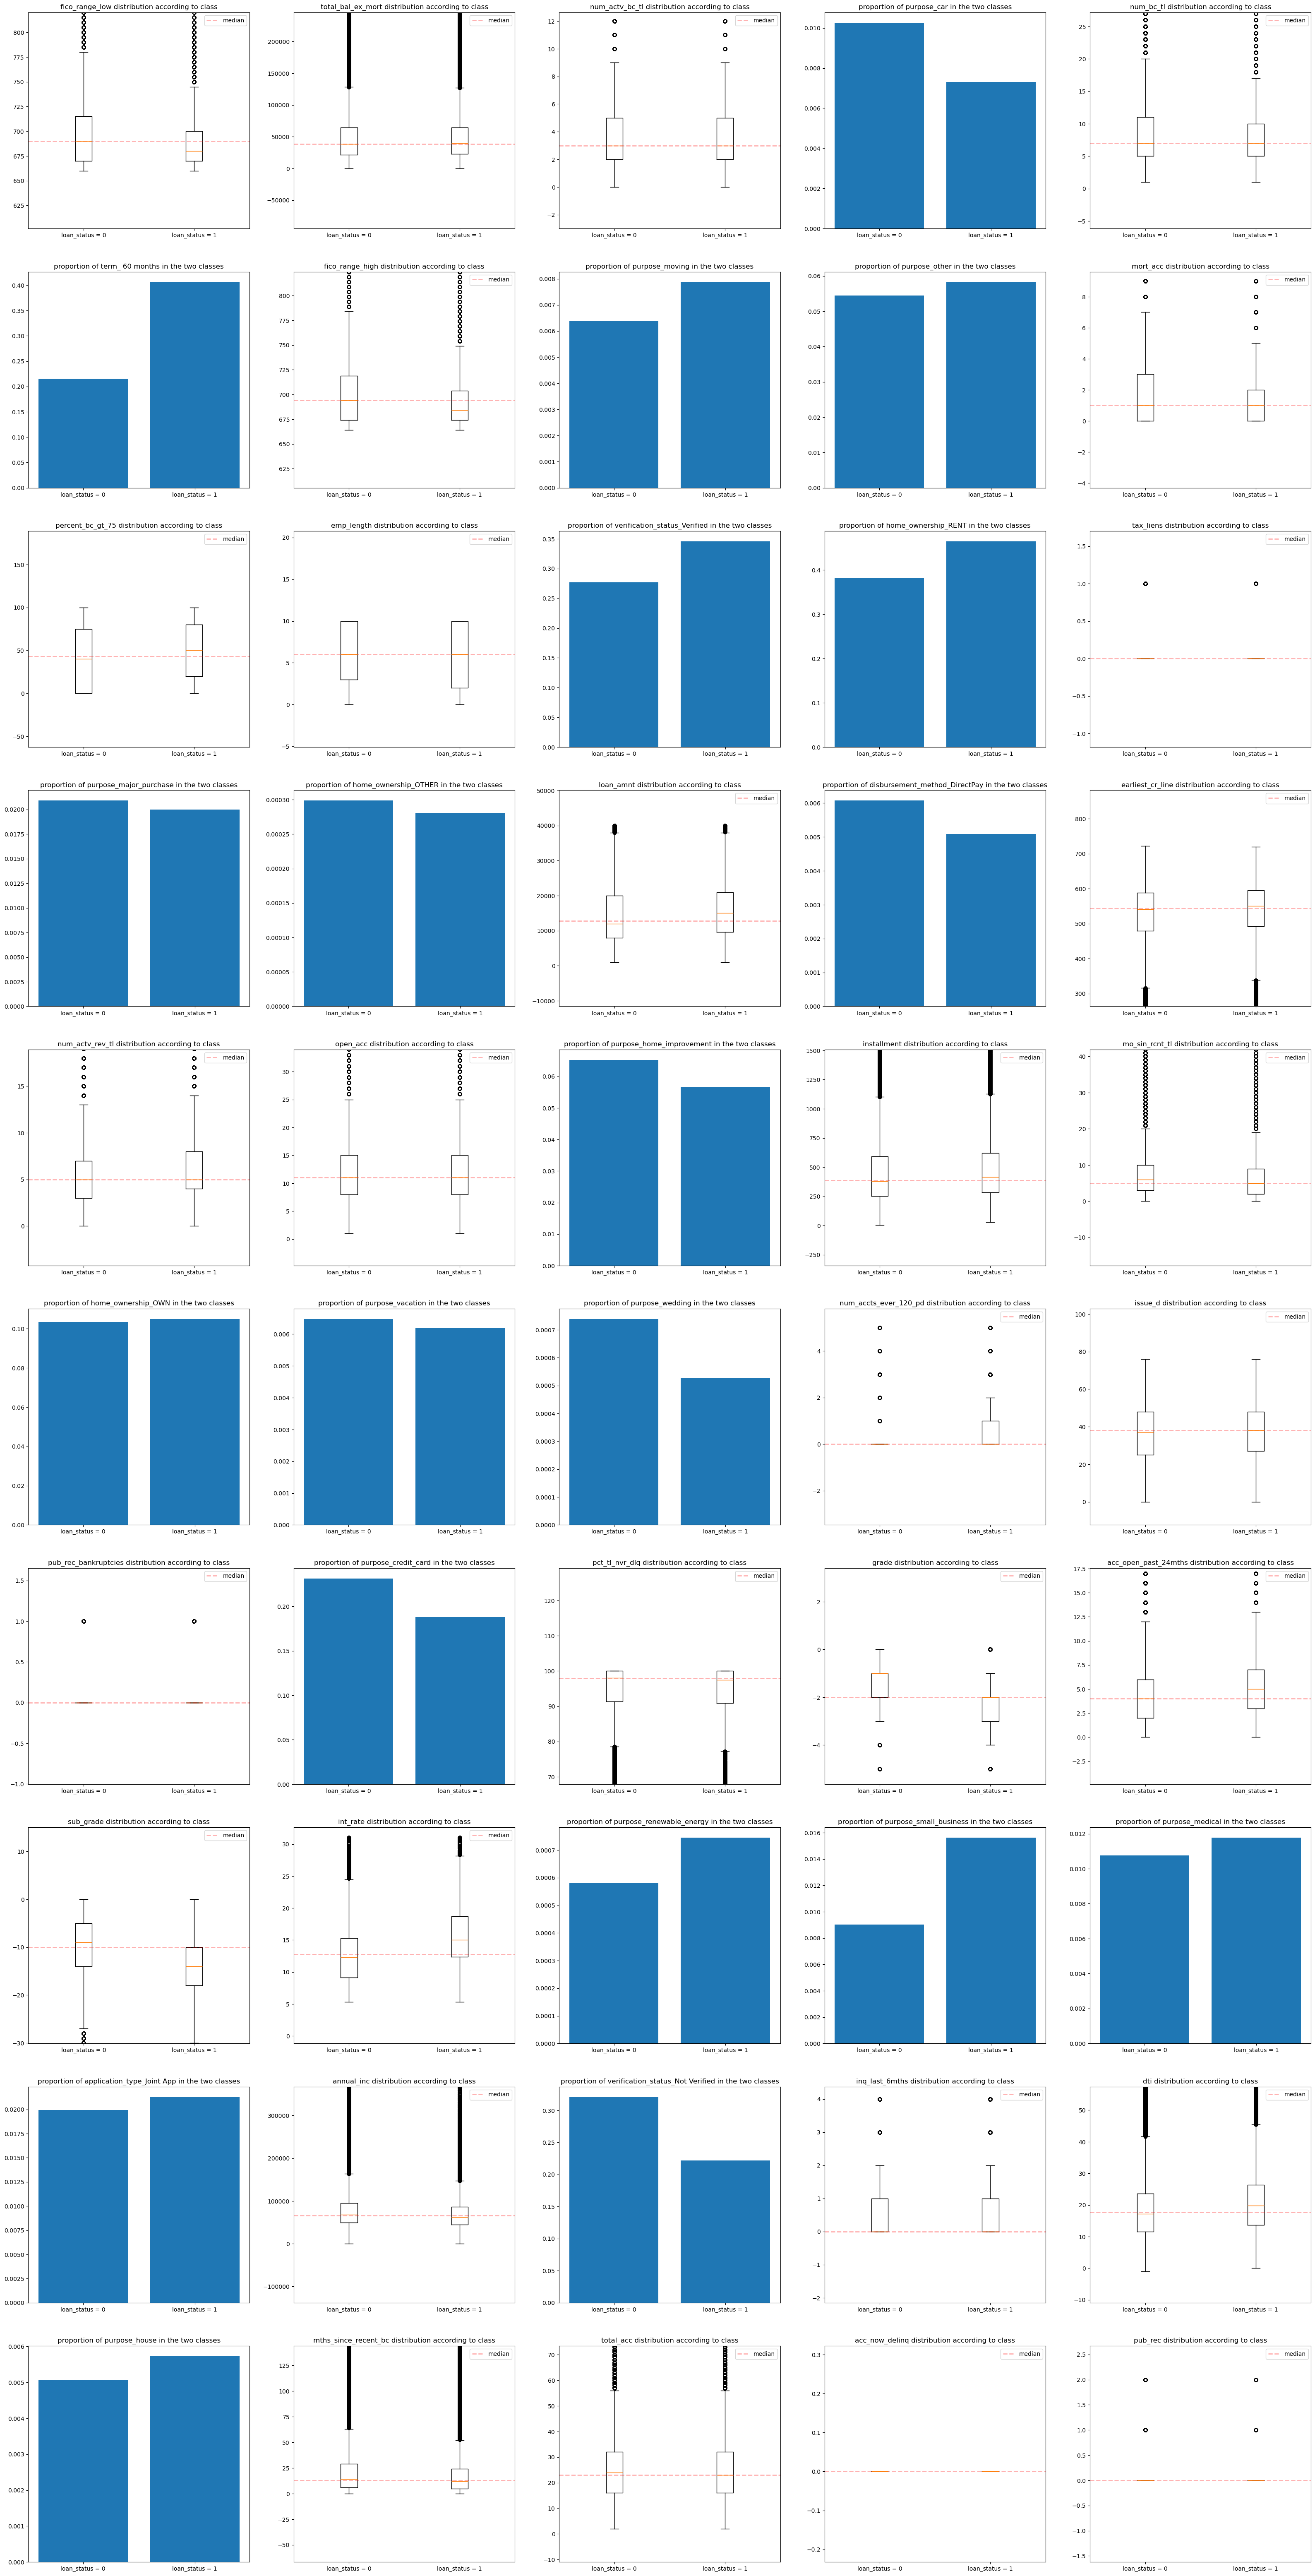

In [19]:
fig, ax = plt.subplots(nrows= 10, ncols= 5, figsize = (40,80))
ax = ax.flatten()

n_loan_status_0 = (df[df.loan_status == 0]).shape[0]
n_loan_status_1 = (df[df.loan_status == 1]).shape[0]
for i,var_name in enumerate(set(df.columns)-set(["loan_status"])):
    if df[var_name].value_counts().size == 2:
        ax[i].bar(x = ("loan_status = 0","loan_status = 1"), height=(df[df.loan_status == 0][var_name].sum()/n_loan_status_0,df[df.loan_status == 1][var_name].sum()/n_loan_status_1))
        ax[i].set_title("proportion of "+var_name +" in the two classes")
    else:
        ax[i].boxplot([df[var_name][df.loan_status == 0],df[var_name][df.loan_status == 1]])
        ax[i].axhline(y=df[var_name].median(), color='r', alpha =0.3, linestyle='--', linewidth=2,label="median")
        ax[i].set_ylim((df[var_name].mean() - 3*df[var_name].std(), df[var_name].mean() + 4*df[var_name].std()))
        ax[i].set_title(var_name + " distribution according to class")
        ax[i].set_xticklabels(("loan_status = 0","loan_status = 1"))
        ax[i].legend()


Splitting into training, validation, testing


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["loan_status"]), df.loan_status, test_size=0.3, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

# undersampling of majority class in train dataset
status_1_idx = ((y_train[y_train == 1]).index).array
status_0_idx = ((y_train[y_train == 0]).index).array
np.random.seed(0)
sampled_idx = np.random.choice(status_0_idx, size = status_1_idx.size, replace = False)
sampled_idx = np.concatenate((sampled_idx, status_1_idx))
print("number of rows in train set before undersampling",X_train.index.size)
print("number of rows in train set after undersampling",sampled_idx.size)

y_train = y_train.loc[sampled_idx]
X_train = X_train.loc[sampled_idx]

number of rows in train set before undersampling 512137
number of rows in train set after undersampling 197440


We standardize the variables

In [20]:
train_means = X_train.mean()
train_stds = X_train.std()
X_train= (X_train-train_means)/train_stds
X_val = (X_val-train_means)/train_stds
X_test = (X_test-train_means)/train_stds

## Linear models


Logistic regression with no penalty

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix

In [22]:
logreg_model = LogisticRegression(penalty = None,max_iter=500)
# we explicitly set the penalty to none so there is no regularization
logreg_model.fit(X_train,y_train)

LogisticRegression(max_iter=500, penalty=None)

In [78]:
logReg_yhat_val = logreg_model.predict(X_val)
logreg_phat_val = logreg_model.predict_proba(X_val)[:,1]

print("L1 norm of coefficients: ", np.abs(logreg_model.coef_).sum())
print("L2 norm of coefficients: ", (logreg_model.coef_**2).sum())
print("accuracy", accuracy_score(y_val,logReg_yhat_val))
print(classification_report(y_val,logReg_yhat_val))
logreg_cm = pd.DataFrame(confusion_matrix(y_val, logReg_yhat_val))
logreg_cm.index.name="actual"
logreg_cm.columns.name="predicted"
print(logreg_cm)

print("Coefficients of unregularized model")
# Coeffs of unregularized model
logreg_coeffs = (pd.Series(logreg_model.coef_[0], index = logreg_model.feature_names_in_)).sort_values()
logreg_coeffs

L1 norm of coefficients:  3.148642485537606
L2 norm of coefficients:  0.8666789120409131
accuracy 0.6564936472324896
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181483  94320
1           22962  42661
Coefficients of unregularized model


sub_grade                          -0.728776
int_rate                           -0.327940
mort_acc                           -0.097483
annual_inc                         -0.087941
fico_range_low                     -0.079104
fico_range_high                    -0.078461
total_acc                          -0.077559
total_bal_ex_mort                  -0.059559
verification_status_Not Verified   -0.049306
mths_since_recent_bc               -0.046357
disbursement_method_DirectPay      -0.032651
application_type_Joint App         -0.031895
emp_length                         -0.027275
purpose_credit_card                -0.024223
num_bc_tl                          -0.017835
pub_rec_bankruptcies               -0.014494
mo_sin_rcnt_tl                     -0.012449
verification_status_Verified       -0.012124
purpose_car                        -0.010574
purpose_wedding                    -0.009802
pct_tl_nvr_dlq                     -0.005323
earliest_cr_line                   -0.004684
home_owner

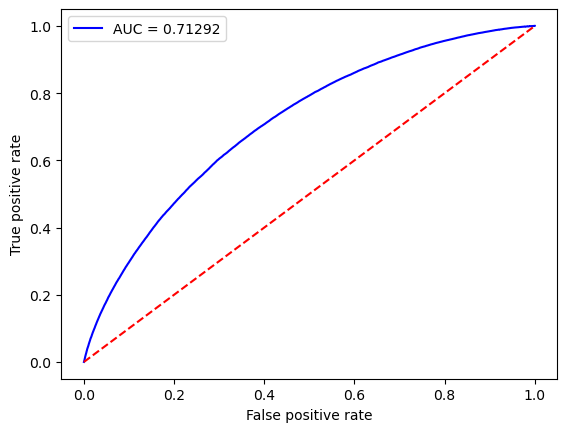

In [24]:
#Roc Curve
logReg_fpr, logReg_tpr, logReg_thresholds = roc_curve(y_val, logreg_phat_val)
logreg_auc_val = roc_auc_score(y_val, logreg_phat_val)
plt.plot(logReg_fpr,logReg_tpr, "b", label = "AUC = %0.5f"%logreg_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

LASSO

In [25]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.
# c_values = np.exp(np.arange(10,-1,-0.25))**-1

#parameter cv= number of folds to use in cross validation

lassocv_model = LogisticRegressionCV(penalty="l1", solver="saga", Cs = 40, cv = 5, max_iter = 3500, n_jobs = -1,verbose = 0)
lassocv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, max_iter=3500, n_jobs=-1, penalty='l1',
                     solver='saga')

In [79]:
lassocv_yhat_val = lassocv_model.predict(X_val)
lassocv_phat_val = lassocv_model.predict_proba(X_val)[:,1]

print("num of coefs that have been shrunk to 0: ", (lassocv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(lassocv_model.coef_).sum())
print("L2 norm of coefficients: ", (lassocv_model.coef_**2).sum())
print("accuracy", accuracy_score(y_val,lassocv_yhat_val))
print(classification_report(y_val,lassocv_yhat_val))
lassocv_cm = pd.DataFrame(confusion_matrix(y_val, lassocv_yhat_val))
lassocv_cm.index.name="actual"
lassocv_cm.columns.name="predicted"
print(lassocv_cm)
print("Coefficients of LASSO model")
lassocv_coeffs=(pd.Series(lassocv_model.coef_[0], index = lassocv_model.feature_names_in_)).sort_values()
lassocv_coeffs

num of coefs that have been shrunk to 0:  2
L1 norm of coefficients:  2.997828957677433
L2 norm of coefficients:  0.7680260604574761
accuracy 0.6566020162494948
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181556  94247
1           22998  42625
Coefficients of LASSO model


sub_grade                          -0.684846
int_rate                           -0.287759
mort_acc                           -0.097702
annual_inc                         -0.084779
fico_range_low                     -0.080567
fico_range_high                    -0.076763
total_acc                          -0.075617
total_bal_ex_mort                  -0.058163
verification_status_Not Verified   -0.048976
mths_since_recent_bc               -0.045691
disbursement_method_DirectPay      -0.031939
application_type_Joint App         -0.031315
emp_length                         -0.026280
purpose_credit_card                -0.023823
num_bc_tl                          -0.016184
mo_sin_rcnt_tl                     -0.011986
verification_status_Verified       -0.011133
purpose_car                        -0.010003
pub_rec_bankruptcies               -0.009922
purpose_wedding                    -0.009212
pct_tl_nvr_dlq                     -0.004989
earliest_cr_line                   -0.002870
home_owner

In [48]:
np.argmax(lassocv_model.Cs_ == lassocv_model.C_)

12

34.551072945922186 	 this is the optimal lambda parameter


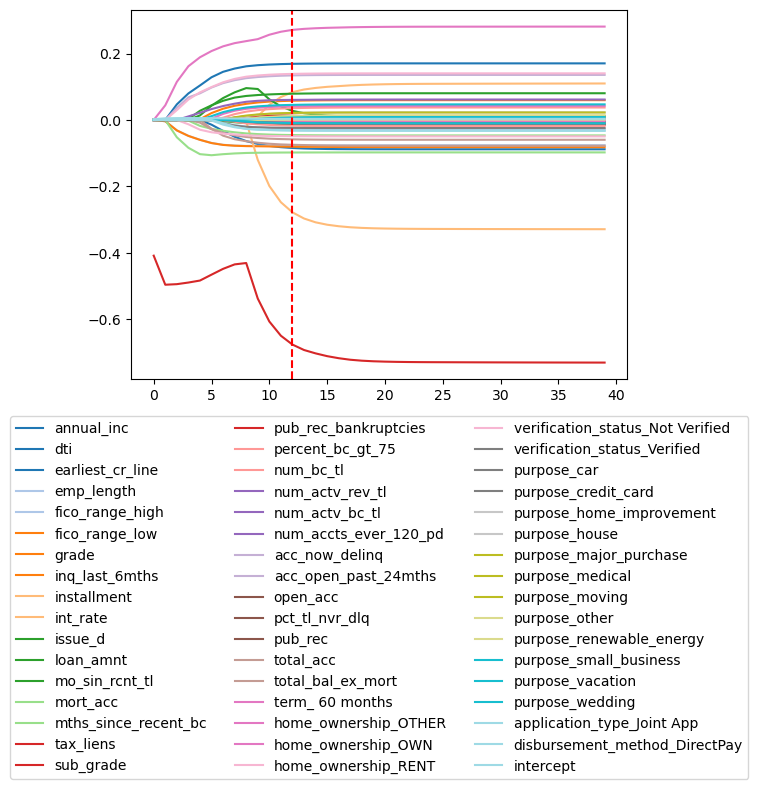

In [64]:
print((lassocv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(lassocv_model.feature_names_in_)
pd.DataFrame(lassocv_model.coefs_paths_[1].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(lassocv_model.Cs_ == lassocv_model.C_),linestyle="--",color="red")
# plt.xticks(range(1,41),labels = lassocv_model.Cs_,size = 5)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.show()

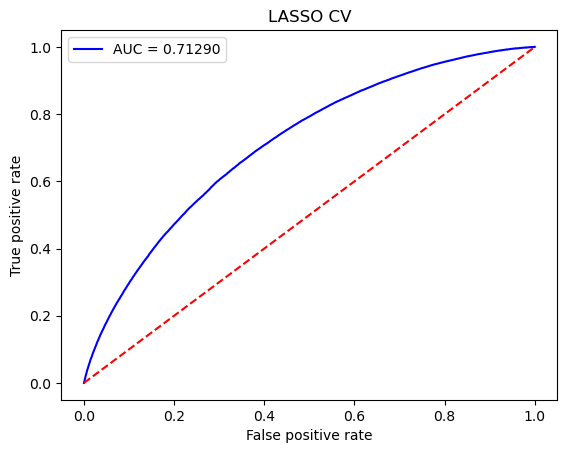

In [41]:
lassocv_fpr, lassocv_tpr, lassocv_thresholds = roc_curve(y_val, lassocv_phat_val)
lassocv_auc_val = roc_auc_score(y_val, lassocv_phat_val)
plt.plot(lassocv_fpr,lassocv_tpr, "b", label = "AUC = %0.5f"%lassocv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("LASSO CV")
plt.show()

Ridge

In [42]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

ridgecv_model = LogisticRegressionCV(penalty="l2", solver="saga", Cs = 40, cv = 5, max_iter = 3500, n_jobs = -1,verbose = 0)
ridgecv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, max_iter=3500, n_jobs=-1, solver='saga')

In [80]:
ridgecv_yhat_val = ridgecv_model.predict(X_val)
ridgecv_phat_val = ridgecv_model.predict_proba(X_val)[:,1]

print("num of coefs that have been shrunk to 0: ", (ridgecv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(ridgecv_model.coef_).sum())
print("L2 norm of coefficients: ", (ridgecv_model.coef_**2).sum())
print("acc_score function from sklearn: ", accuracy_score(y_val,ridgecv_yhat_val))
print(classification_report(y_val,ridgecv_yhat_val))
ridgecv_cm = pd.DataFrame(confusion_matrix(y_val, ridgecv_yhat_val))
ridgecv_cm.index.name="actual"
ridgecv_cm.columns.name="predicted"
print(ridgecv_cm)
print("Coefficients of Ridge")
ridgecv_coeffs = (pd.Series(ridgecv_model.coef_[0], index = ridgecv_model.feature_names_in_)).sort_values()
ridgecv_coeffs


num of coefs that have been shrunk to 0:  0
L1 norm of coefficients:  3.138636341840002
L2 norm of coefficients:  0.8568818210874288
acc_score function from sklearn:  0.6564877894477866
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181478  94325
1           22959  42664
Coefficients of Ridge


sub_grade                          -0.723905
int_rate                           -0.324873
mort_acc                           -0.097528
annual_inc                         -0.088041
fico_range_low                     -0.079923
fico_range_high                    -0.077701
total_acc                          -0.077520
total_bal_ex_mort                  -0.059538
verification_status_Not Verified   -0.049347
mths_since_recent_bc               -0.046379
disbursement_method_DirectPay      -0.032658
application_type_Joint App         -0.031936
emp_length                         -0.027274
purpose_credit_card                -0.024248
num_bc_tl                          -0.017890
pub_rec_bankruptcies               -0.014540
mo_sin_rcnt_tl                     -0.012447
verification_status_Verified       -0.012140
purpose_car                        -0.010575
purpose_wedding                    -0.009807
pct_tl_nvr_dlq                     -0.005338
earliest_cr_line                   -0.004667
home_owner

5.2233450742668435 	 this is the optimal lambda parameter


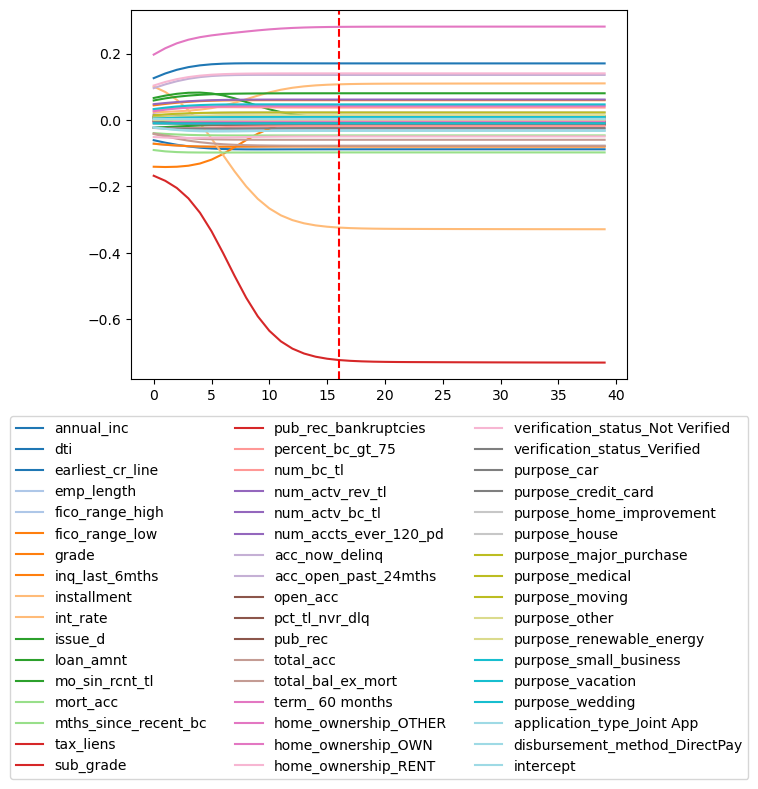

In [63]:
print((ridgecv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(ridgecv_model.feature_names_in_)
pd.DataFrame(ridgecv_model.coefs_paths_[1].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(ridgecv_model.Cs_ == ridgecv_model.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.show()

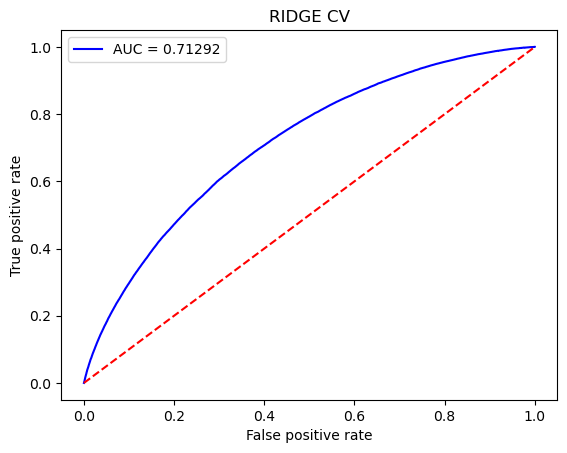

In [65]:
ridgecv_fpr, ridgecv_tpr, ridgecv_thresholds = roc_curve(y_val, ridgecv_phat_val)
ridgecv_auc_val = roc_auc_score(y_val, ridgecv_phat_val)
plt.plot(ridgecv_fpr,ridgecv_tpr, "b", label = "AUC = %0.5f"%ridgecv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("RIDGE CV")
plt.show()

Elastic net

In [66]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

elasticnetcv_model = LogisticRegressionCV(penalty="elasticnet", solver="saga", Cs = 40, cv = 5, 
                                          l1_ratios= [0.5], max_iter = 3500, n_jobs = -1,verbose = 0)
elasticnetcv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, l1_ratios=[0.5], max_iter=3500, n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [81]:
elasticnetcv_yhat_val = elasticnetcv_model.predict(X_val)
elasticnetcv_phat_val = elasticnetcv_model.predict_proba(X_val)[:,1]
print("num of coefs that have been shrunk to 0: ", (elasticnetcv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(elasticnetcv_model.coef_).sum())
print("L2 norm of coefficients: ", (elasticnetcv_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,elasticnetcv_yhat_val))
print(classification_report(y_val,elasticnetcv_yhat_val))
elasticnetcv_cm = pd.DataFrame(confusion_matrix(y_val, elasticnetcv_yhat_val))
elasticnetcv_cm.index.name="actual"
elasticnetcv_cm.columns.name="predicted"
print(elasticnetcv_cm)
print("coefficients of Elastic net")
elasticnetcv_coeffs = (pd.Series(elasticnetcv_model.coef_[0], index = elasticnetcv_model.feature_names_in_)).sort_values()
elasticnetcv_coeffs

num of coefs that have been shrunk to 0:  2
L1 norm of coefficients:  2.99236462803046
L2 norm of coefficients:  0.7517134272262908
accuracy:  0.6566518074194702
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181560  94243
1           22985  42638
coefficients of Elastic net


sub_grade                          -0.676126
int_rate                           -0.279662
mort_acc                           -0.097717
annual_inc                         -0.085501
fico_range_low                     -0.079666
fico_range_high                    -0.077992
total_acc                          -0.075675
total_bal_ex_mort                  -0.058396
verification_status_Not Verified   -0.049241
mths_since_recent_bc               -0.045849
disbursement_method_DirectPay      -0.032120
application_type_Joint App         -0.031679
emp_length                         -0.026471
purpose_credit_card                -0.024022
num_bc_tl                          -0.016756
mo_sin_rcnt_tl                     -0.012191
verification_status_Verified       -0.011518
pub_rec_bankruptcies               -0.010907
purpose_car                        -0.010120
purpose_wedding                    -0.009358
pct_tl_nvr_dlq                     -0.005110
earliest_cr_line                   -0.003163
home_owner

55.41020330009492 	 this is the optimal lambda parameter


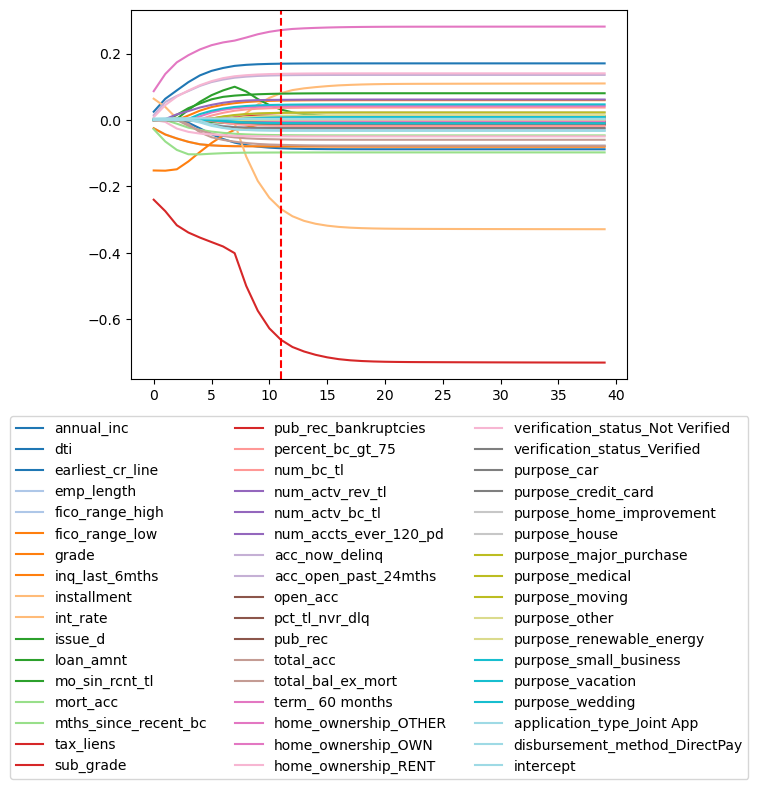

In [68]:
print((elasticnetcv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(elasticnetcv_model.feature_names_in_)
pd.DataFrame(elasticnetcv_model.coefs_paths_[1][:,:,0,:].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(elasticnetcv_model.Cs_ == elasticnetcv_model.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.show()

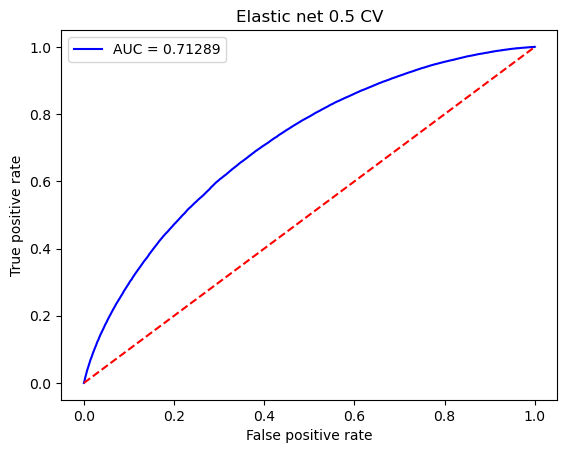

In [82]:
elasticnetcv_fpr, elasticnetcv_tpr, elasticnetcv_thresholds = roc_curve(y_val, elasticnetcv_phat_val)
elasticnetcv_auc_val = roc_auc_score(y_val, elasticnetcv_phat_val)
plt.plot(elasticnetcv_fpr,elasticnetcv_tpr, "b", label = "AUC = %0.5f"%elasticnetcv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net 0.5 CV")
plt.show()

Elastic net with a high penalty

In [86]:
elasticnetcv_model.Cs_[:13]

array([0.0001    , 0.00016037, 0.00025719, 0.00041246, 0.00066147,
       0.00106082, 0.00170125, 0.00272833, 0.00437548, 0.00701704,
       0.01125336, 0.01804722, 0.02894266])

In [108]:
from sklearn.linear_model import LogisticRegression
en_highreg_model = LogisticRegression(penalty = "elasticnet", l1_ratio = 0.5, C = 0.00035,
                                  max_iter=3500, solver = "saga", n_jobs=-1)
# we chose a high regularization parameter to force the model to pick only a few features
en_highreg_model.fit(X_train,y_train)

LogisticRegression(C=0.00035, l1_ratio=0.5, max_iter=3500, n_jobs=-1,
                   penalty='elasticnet', solver='saga')

In [109]:
en_highreg_yhat_val = en_highreg_model.predict(X_val)
en_highreg_phat_val = en_highreg_model.predict_proba(X_val)[:,1]
print("num of coefs that have been shrunk to 0: ", (en_highreg_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(en_highreg_model.coef_).sum())
print("L2 norm of coefficients: ", (en_highreg_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,en_highreg_yhat_val))
print(classification_report(y_val,en_highreg_yhat_val))
en_highreg_cm = pd.DataFrame(confusion_matrix(y_val, en_highreg_yhat_val))
en_highreg_cm.index.name="actual"
en_highreg_cm.columns.name="predicted"
print(en_highreg_cm)
print("coefficients of Elastic net")
en_highreg_coeffs = (pd.Series(en_highreg_model.coef_[0], index = en_highreg_model.feature_names_in_)).sort_values()
en_highreg_coeffs

num of coefs that have been shrunk to 0:  31
L1 norm of coefficients:  1.4199602862898801
L2 norm of coefficients:  0.22545998301287867
accuracy:  0.6577706442977395
              precision    recall  f1-score   support

           0       0.88      0.66      0.76    275803
           1       0.31      0.64      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.77      0.66      0.69    341426

predicted       0      1
actual                  
0          182767  93036
1           23810  41813
coefficients of Elastic net


sub_grade                          -0.340643
grade                              -0.121074
mort_acc                           -0.103676
fico_range_low                     -0.066813
fico_range_high                    -0.066737
verification_status_Not Verified   -0.036554
mths_since_recent_bc               -0.024080
total_bal_ex_mort                  -0.019530
total_acc                          -0.015906
annual_inc                         -0.010122
home_ownership_OTHER                0.000000
home_ownership_OWN                  0.000000
verification_status_Verified        0.000000
purpose_car                         0.000000
purpose_credit_card                 0.000000
purpose_home_improvement            0.000000
purpose_house                       0.000000
purpose_major_purchase              0.000000
purpose_medical                     0.000000
purpose_moving                      0.000000
purpose_other                       0.000000
purpose_renewable_energy            0.000000
purpose_va

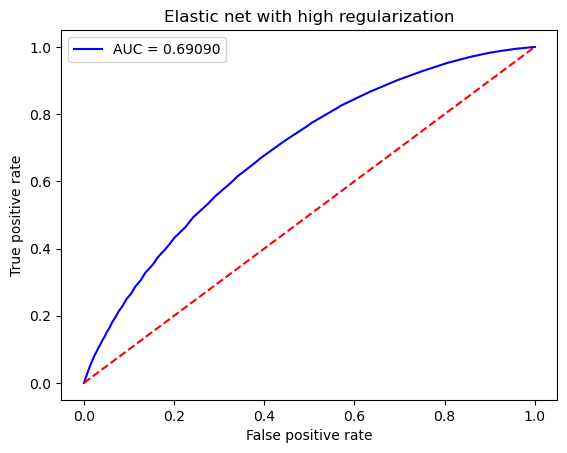

In [103]:
en_highreg_fpr, en_highreg_tpr, en_highreg_thresholds = roc_curve(y_val, en_highreg_phat_val)
en_highreg_auc_val = roc_auc_score(y_val, en_highreg_phat_val)
plt.plot(en_highreg_fpr,en_highreg_tpr, "b", label = "AUC = %0.5f"%en_highreg_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net with high regularization")
plt.show()

In [135]:
en_highreg_coeffs > 0

sub_grade                           False
grade                               False
mort_acc                            False
fico_range_low                      False
fico_range_high                     False
verification_status_Not Verified    False
mths_since_recent_bc                False
total_bal_ex_mort                   False
total_acc                           False
annual_inc                          False
home_ownership_OTHER                False
home_ownership_OWN                  False
verification_status_Verified        False
purpose_car                         False
purpose_credit_card                 False
purpose_home_improvement            False
purpose_house                       False
purpose_major_purchase              False
purpose_medical                     False
purpose_moving                      False
purpose_other                       False
purpose_renewable_energy            False
purpose_vacation                    False
purpose_wedding                   

<BarContainer object of 50 artists>

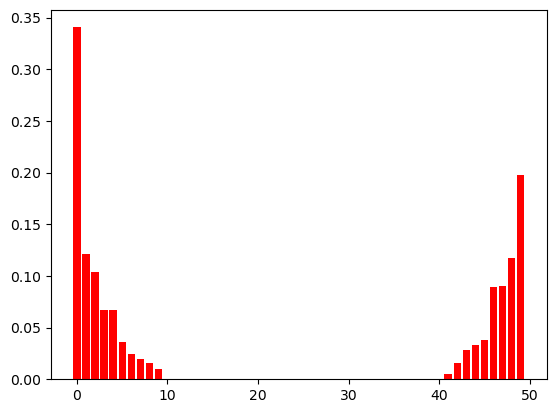

In [137]:
fig, ax = plt.subplots()
ax.bar(np.arange(50),np.abs(en_highreg_coeffs), color = "red")

Correlation between models' coefficients

In [113]:
pd.DataFrame(data={"log_reg":logreg_coeffs,"Lasso_CV":lassocv_coeffs,"Ridge_CV":ridgecv_coeffs,"ElasticNetCV":elasticnetcv_coeffs,"ElasticNet_High":en_highreg_coeffs}).corr()

,log_reg,Lasso_CV,Ridge_CV,ElasticNetCV,ElasticNet_High
log_reg,1.000000,0.998967,0.999989,0.998530,0.859954
Lasso_CV,0.998967,1.000000,0.999138,0.999946,0.876736
Ridge_CV,0.999989,0.999138,1.000000,0.998737,0.861553
ElasticNetCV,0.998530,0.999946,0.998737,1.000000,0.879361
ElasticNet_High,0.859954,0.876736,0.861553,0.879361,1.000000


## Tree based models

Random forest


Il parametro n_estimators nel costruttore RandomForestClassifier indica il numero di alberi decisionali che compongono il Random Forest.

Aumentare il valore di n_estimators generalmente porta a una maggiore complessità del modello e può migliorare le prestazioni predittive, riducendo il rischio di overfitting. Tuttavia, aumentare n_estimators può anche aumentare il tempo di addestramento e il consumo di memoria.

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

random_forest = RandomForestClassifier(n_estimators=500, random_state=42)

# Addestra il classificatore sul set di addestramento
random_forest.fit(X_train, y_train)

# Effettua previsioni sul set di test
random_forest_yhat_val = random_forest.predict(X_val)

# Valuta l'accuratezza del modello
classification_report_random_forest = classification_report(y_val, random_forest_yhat_val)
print("risultati:\n", f"accuracy: {accuracy_score(y_val,random_forest_yhat_val):5f}", classification_report_random_forest,sep="\n")

risultati:

accuracy: 0.646225
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    275803
           1       0.31      0.68      0.43     65623

    accuracy                           0.65    341426
   macro avg       0.60      0.66      0.59    341426
weighted avg       0.78      0.65      0.68    341426



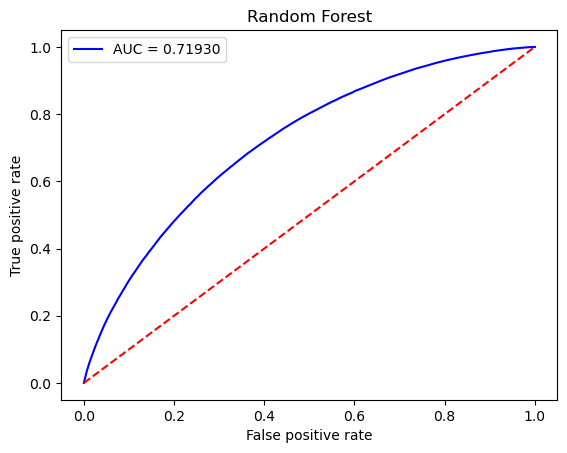

In [181]:
random_forest_phat_val = random_forest.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_val, random_forest_phat_val)
random_forest_auc_val = roc_auc_score(y_val, random_forest_phat_val)
plt.plot(fpr,tpr, "b", label = "AUC = %0.5f"%random_forest_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Random Forest")
plt.show()

XGBOOST


In [179]:
import xgboost as xgb

# Crea un oggetto DMatrix XGBoost per i dati di addestramento e test
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Definisci i parametri per il modello XGBoost
params = {
    'objective': 'binary:logistic',  # obiettivo: è classificazione binaria
    'eval_metric': 'auc'  # metrica di valutazione: auc
}

# Addestra il modello XGBoost
num_rounds = 5000
model = xgb.train(params, dtrain, num_rounds)

# Effettua le previsioni sul set di test
predictions = model.predict(dval)

# Calcola l'AUC-ROC
auc_roc = roc_auc_score(y_val, predictions)
print("AUC-ROC:", auc_roc)

#accuracy
print(accuracy_score(y_val, predictions>0.5))

AUC-ROC: 0.6808787001640767
0.62475909860409



Per trovare i coefficienti in un modello XGBoost (Extreme Gradient Boosting), devi prima comprendere che XGBoost non utilizza coefficienti nel modo in cui lo fanno i modelli lineari come la regressione lineare. Invece, XGBoost addestra un insieme di alberi decisionali, ognuno dei quali fornisce contributi alle previsioni finali.

Se intendi trovare l'importanza delle feature nel modello XGBoost, puoi farlo utilizzando l'attributo feature_importances_. Questo attributo restituirà un array contenente l'importanza relativa di ciascuna feature nel modello. Puoi ottenere una rappresentazione grafica di queste importanze utilizzando la libreria matplotlib.

**weight**: Questo tipo di importanza rappresenta il numero di volte in cui una feature è stata utilizzata per suddividere i dati in tutti gli alberi del modello. È un'indicazione di quanto spesso una feature è stata considerata importante per la divisione dei dati.

**gain**: Questo tipo di importanza rappresenta il guadagno medio ottenuto quando una feature è stata utilizzata per dividere i dati in tutti gli alberi del modello. Il guadagno è una misura di quanto il modello ha ridotto l'errore utilizzando quella particolare feature per dividere i dati.

**cover**: Questo tipo di importanza rappresenta la copertura media ottenuta quando una feature è stata utilizzata per dividere i dati in tutti gli alberi del modello. La copertura è una misura della quantità di dati che vengono gestiti da una particolare divisione.

**total_gain**: Questo tipo di importanza rappresenta il guadagno totale ottenuto quando una feature è stata utilizzata per dividere i dati in tutti gli alberi del modello. È la somma del guadagno su tutte le divisioni in cui la feature è stata coinvolta.

**total_cover**: Questo tipo di importanza rappresenta la copertura totale ottenuta quando una feature è stata utilizzata per dividere i dati in tutti gli alberi del modello. È la somma della copertura su tutte le divisioni in cui la feature è stata coinvolta.

<Figure size 2500x2500 with 0 Axes>

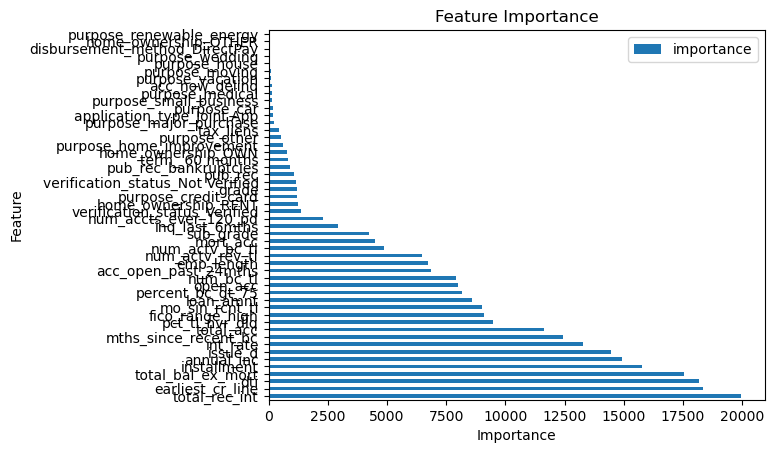

In [133]:
# Ottieni l'importanza delle feature
importance = model.get_score(importance_type='weight')

# Converti l'importanza delle feature in un DataFrame
importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['importance'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Visualizza l'importanza delle feature
plt.figure(figsize=(25, 25))
importance_df.plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

<Axes: ylabel='Frequency'>

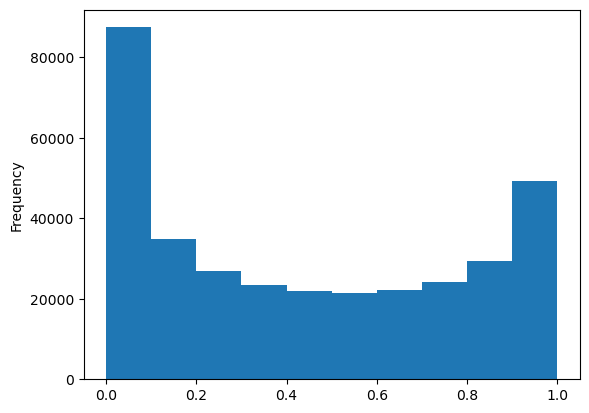

In [39]:
pd.Series(predictions).plot(kind="hist")

In [40]:
sorted(importance.items(),key = lambda item: item[1],reverse=True)

[('earliest_cr_line', 20510.0),
 ('dti', 20282.0),
 ('total_bal_ex_mort', 19968.0),
 ('installment', 16998.0),
 ('annual_inc', 16682.0),
 ('issue_d', 15405.0),
 ('mths_since_recent_bc', 13909.0),
 ('int_rate', 13774.0),
 ('total_acc', 13058.0),
 ('pct_tl_nvr_dlq', 10349.0),
 ('fico_range_high', 9925.0),
 ('mo_sin_rcnt_tl', 9885.0),
 ('loan_amnt', 9651.0),
 ('open_acc', 9086.0),
 ('percent_bc_gt_75', 8900.0),
 ('num_bc_tl', 8824.0),
 ('acc_open_past_24mths', 7534.0),
 ('emp_length', 7315.0),
 ('num_actv_rev_tl', 7215.0),
 ('num_actv_bc_tl', 5383.0),
 ('mort_acc', 4974.0),
 ('sub_grade', 4443.0),
 ('inq_last_6mths', 3281.0),
 ('num_accts_ever_120_pd', 2423.0),
 ('home_ownership_RENT', 1397.0),
 ('verification_status_Verified', 1392.0),
 ('purpose_credit_card', 1341.0),
 ('verification_status_Not Verified', 1291.0),
 ('grade', 1252.0),
 ('pub_rec', 1245.0),
 ('pub_rec_bankruptcies', 919.0),
 ('home_ownership_OWN', 843.0),
 ('term_ 60 months', 797.0),
 ('purpose_home_improvement', 628.0),


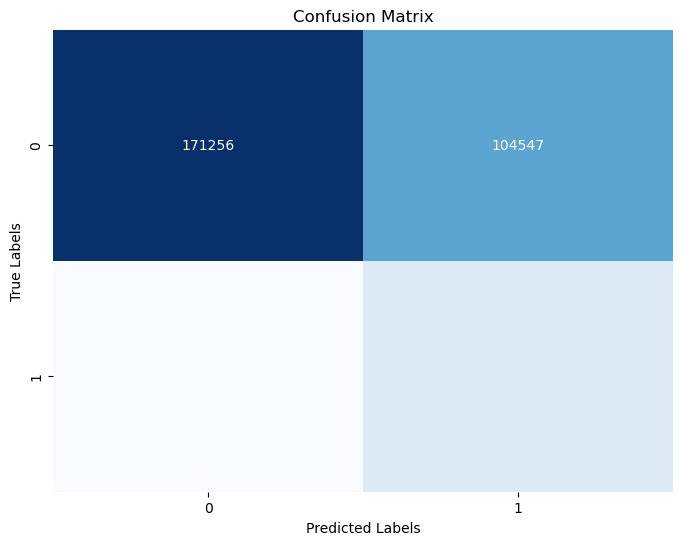

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, predictions > 0.5)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
cm

array([[171256, 104547],
       [ 23570,  42053]], dtype=int64)

In [43]:
# Estrai i valori dalla matrice di confusione
tn, fp, fn, tp = cm.ravel()
# Calcola la sensitivity
sensitivity = tp / (tp + fn)
# Calcola la specificity
specificity = tn / (tn + fp)
predizione_rate = (tp+tn)/(tn+tp+fp+fn)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", predizione_rate)

Sensitivity: 0.6408271490178749
Specificity: 0.6209359579119879
Accuracy: 0.62475909860409


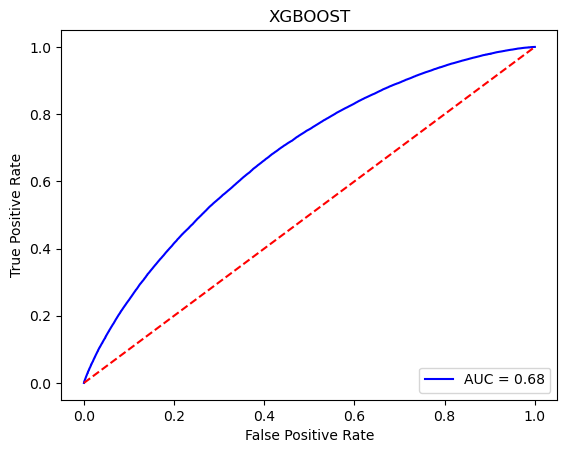

In [44]:
from sklearn.metrics import auc
fpr, tpr, threshold = roc_curve(y_val, predictions)
roc_auc_xgboost = auc(fpr, tpr)
plt.title('XGBOOST')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_xgboost)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([-0.01, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_auc_data = {"uniform":{},"distance":{}}
knn_phat_val_dict = {"uniform":{},"distance":{}}
knn_accuracy_val_dict = {"uniform":{},"distance":{}}

for n_neighbors in range(2,322):
    for weight_type in ("uniform","distance"):
        knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors = n_neighbors,weights=weight_type)
        knn_model.fit(X_train, y_train)
        knn_phat_val = knn_model.predict_proba(X_val)[:,1]
        knn_phat_val_dict[weight_type][n_neighbors] = knn_phat_val
        knn_auc = roc_auc_score(y_val,knn_phat_val)
        knn_auc_data[weight_type][n_neighbors] = knn_auc
        knn_accuracy = accuracy_score(y_val,knn_phat_val > 0.5)
        knn_accuracy_val_dict[weight_type][n_neighbors] = knn_accuracy
        print("n_neighbors", n_neighbors,"weights", weight_type,"auc", knn_auc, "accuracy", knn_accuracy)


n_neighbors 2 weights uniform auc 0.6009013838792117 accuracy 0.7020174210517066
n_neighbors 2 weights distance auc 0.6017077210888006 accuracy 0.5729645662603317
n_neighbors 3 weights uniform auc 0.6186146790871909 accuracy 0.59382999537235
n_neighbors 3 weights distance auc 0.6197303253321198 accuracy 0.5938270664799986
n_neighbors 4 weights uniform auc 0.6312255034361164 accuracy 0.680613075747014
n_neighbors 4 weights distance auc 0.6322701006418769 accuracy 0.5946705874772279
n_neighbors 5 weights uniform auc 0.6396139322982046 accuracy 0.604804555013385
n_neighbors 5 weights distance auc 0.6409755036779665 accuracy 0.6047811238745732
n_neighbors 6 weights uniform auc 0.647065250076493 accuracy 0.6709887354800161
n_neighbors 6 weights distance auc 0.6482153628555616 accuracy 0.6056334315488568
n_neighbors 7 weights uniform auc 0.6531740066752891 accuracy 0.6124196751272604
n_neighbors 7 weights distance auc 0.6541042463650495 accuracy 0.612381599526691
n_neighbors 8 weights unifor

In [62]:
for n_neighbors in range(10,21):
    for weight_type in ("uniform","distance"):
        knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors = n_neighbors,weights=weight_type)
        knn_model.fit(X_train, y_train)
        knn_phat_val = knn_model.predict_proba(X_val)
        knn_auc = roc_auc_score(y_val,knn_phat_val[:,1])
        knn_auc_data[weight_type][n_neighbors] = knn_auc
        print("n_neighbors", n_neighbors,"weights", weight_type,"auc", knn_auc)

n_neighbors 10 weights uniform auc 0.6656639732944873
n_neighbors 10 weights distance auc 0.6663979761190907
n_neighbors 11 weights uniform auc 0.6687307451790997
n_neighbors 11 weights distance auc 0.6693960643688144
n_neighbors 12 weights uniform auc 0.671416462736047
n_neighbors 12 weights distance auc 0.672041380374234
n_neighbors 13 weights uniform auc 0.6739255929721065
n_neighbors 13 weights distance auc 0.6745191407078588
n_neighbors 14 weights uniform auc 0.6760332657871561
n_neighbors 14 weights distance auc 0.6765750063540082
n_neighbors 15 weights uniform auc 0.6780973870735434
n_neighbors 15 weights distance auc 0.6786072064926533
n_neighbors 16 weights uniform auc 0.6800760408607507
n_neighbors 16 weights distance auc 0.6805376931146195
n_neighbors 17 weights uniform auc 0.6816053267330588
n_neighbors 17 weights distance auc 0.6820530447796473
n_neighbors 18 weights uniform auc 0.6830495441885622
n_neighbors 18 weights distance auc 0.6834665537773591
n_neighbors 19 weight

In [67]:
knn_phat_val_dict = {"uniform":{},"distance":{}}
knn_accuracy_val_dict = {"uniform":{},"distance":{}}

for n_neighbors in range(32,35):
    for weight_type in ("uniform","distance"):
        knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors = n_neighbors,weights=weight_type)
        knn_model.fit(X_train, y_train)
        knn_phat_val = knn_model.predict_proba(X_val)[:,1]
        knn_phat_val_dict[weight_type][n_neighbors] = knn_phat_val
        knn_auc = roc_auc_score(y_val,knn_phat_val)
        knn_auc_data[weight_type][n_neighbors] = knn_auc
        knn_accuracy = accuracy_score(y_val,knn_phat_val > 0.5)
        knn_accuracy_val_dict[weight_type][n_neighbors] = knn_accuracy
        print("n_neighbors", n_neighbors,"weights", weight_type,"auc", knn_auc, "accuracy", knn_accuracy)

n_neighbors 32 weights uniform auc 0.6954918460454043 accuracy 0.6521413131981747
n_neighbors 32 weights distance auc 0.6957558576840996 accuracy 0.6342750698540826
n_neighbors 33 weights uniform auc 0.6960393233592439 accuracy 0.6347466215226726
n_neighbors 33 weights distance auc 0.696303027025468 accuracy 0.6348315594008658
n_neighbors 34 weights uniform auc 0.6964850334794662 accuracy 0.6516258281443124
n_neighbors 34 weights distance auc 0.6967524248038621 accuracy 0.634778839338539


In [68]:
knn_phat_val_dict = {"uniform":{},"distance":{}}
knn_accuracy_val_dict = {"uniform":{},"distance":{}}

for n_neighbors in range(50,52):
    for weight_type in ("uniform","distance"):
        knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors = n_neighbors,weights=weight_type)
        knn_model.fit(X_train, y_train)
        knn_phat_val = knn_model.predict_proba(X_val)[:,1]
        knn_phat_val_dict[weight_type][n_neighbors] = knn_phat_val
        knn_auc = roc_auc_score(y_val,knn_phat_val)
        knn_auc_data[weight_type][n_neighbors] = knn_auc
        knn_accuracy = accuracy_score(y_val,knn_phat_val > 0.5)
        knn_accuracy_val_dict[weight_type][n_neighbors] = knn_accuracy
        print("n_neighbors", n_neighbors,"weights", weight_type,"auc", knn_auc, "accuracy", knn_accuracy)

n_neighbors 50 weights uniform auc 0.7012684512122086 accuracy 0.6485446333905444
n_neighbors 50 weights distance auc 0.7015491970992499 accuracy 0.6366709037976018
n_neighbors 51 weights uniform auc 0.7015581947409775 accuracy 0.6367060505058197
n_neighbors 51 weights distance auc 0.7018292429207733 accuracy 0.6368378506616368


In [69]:
knn_phat_val_dict = {"uniform":{},"distance":{}}
knn_accuracy_val_dict = {"uniform":{},"distance":{}}

for n_neighbors in range(70,72):
    for weight_type in ("uniform","distance"):
        knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors = n_neighbors,weights=weight_type)
        knn_model.fit(X_train, y_train)
        knn_phat_val = knn_model.predict_proba(X_val)[:,1]
        knn_phat_val_dict[weight_type][n_neighbors] = knn_phat_val
        knn_auc = roc_auc_score(y_val,knn_phat_val)
        knn_auc_data[weight_type][n_neighbors] = knn_auc
        knn_accuracy = accuracy_score(y_val,knn_phat_val > 0.5)
        knn_accuracy_val_dict[weight_type][n_neighbors] = knn_accuracy
        print("n_neighbors", n_neighbors,"weights", weight_type,"auc", knn_auc, "accuracy", knn_accuracy)

n_neighbors 70 weights uniform auc 0.7048131988033192 accuracy 0.6476073878380674
n_neighbors 70 weights distance auc 0.7050442937983982 accuracy 0.6386947684124817
n_neighbors 71 weights uniform auc 0.7049642858212548 accuracy 0.6388002085371354
n_neighbors 71 weights distance auc 0.7051927528840318 accuracy 0.6385190348713924


In [70]:
knn_phat_val_dict = {"uniform":{},"distance":{}}
knn_accuracy_val_dict = {"uniform":{},"distance":{}}

for n_neighbors in range(320,322):
    for weight_type in ("uniform","distance"):
        knn_model = KNeighborsClassifier(n_jobs=-1, n_neighbors = n_neighbors,weights=weight_type)
        knn_model.fit(X_train, y_train)
        knn_phat_val = knn_model.predict_proba(X_val)[:,1]
        knn_phat_val_dict[weight_type][n_neighbors] = knn_phat_val
        knn_auc = roc_auc_score(y_val,knn_phat_val)
        knn_auc_data[weight_type][n_neighbors] = knn_auc
        knn_accuracy = accuracy_score(y_val,knn_phat_val > 0.5)
        knn_accuracy_val_dict[weight_type][n_neighbors] = knn_accuracy
        print("n_neighbors", n_neighbors,"weights", weight_type,"auc", knn_auc, "accuracy", knn_accuracy)

n_neighbors 320 weights uniform auc 0.7104914538122948 accuracy 0.6442098727103384
n_neighbors 320 weights distance auc 0.7107760281386091 accuracy 0.6422738748660032
n_neighbors 321 weights uniform auc 0.7104812393643716 accuracy 0.6419956300926116
n_neighbors 321 weights distance auc 0.710767475686725 accuracy 0.6422152970189734


Some idea: how to evaluate the performance of a model:
We estimate on test set the interest earned on loans that were true positive, i.e. that our model would have approved and they actually paid back. To that amount we subtract the loss the model incurs by approving loans that defaulted.

More formally:

$max\quad profit = \sum -1^{I(y\ne0)} \cdot (1-\hat y)(C\cdot r)$ also we have to subtract the loss in case the loan defaults

How we evaluate a classifier:

if a loan is approved, i.e. classified as a negative, loan status = 0:

- if it was a true negative we add the interest earned to profits
- if it was a false negative we subtract an average loss multiplied by the loan amount 

In [76]:
original_X_test = X_test[["int_rate","loan_amnt","term_ 60 months"]]*train_stds[["int_rate","loan_amnt","term_ 60 months"]] + train_means[["int_rate","loan_amnt","term_ 60 months"]]
original_X_test

,int_rate,loan_amnt,term_ 60 months
242541,6.92,14000.0,0.0
185270,8.18,6000.0,0.0
17960,5.32,16000.0,0.0
997399,16.29,22050.0,1.0
1044766,18.75,15675.0,0.0
...,...,...,...
740715,14.99,19875.0,0.0
82787,13.99,21000.0,1.0
741367,16.99,16025.0,1.0
844143,6.03,5250.0,0.0


In [81]:
original_X_test["total_interest"] = (original_X_test.loan_amnt * (original_X_test.int_rate/100)).apply(lambda x : x*3)
original_X_test.total_interest[original_X_test["term_ 60 months"] == 1] = original_X_test.total_interest/3*5
original_X_test

,int_rate,loan_amnt,term_ 60 months,total_interest
242541,6.92,14000.0,0.0,2906.4000
185270,8.18,6000.0,0.0,1472.4000
17960,5.32,16000.0,0.0,2553.6000
997399,16.29,22050.0,1.0,17959.7250
1044766,18.75,15675.0,0.0,8817.1875
...,...,...,...,...
740715,14.99,19875.0,0.0,8937.7875
82787,13.99,21000.0,1.0,14689.5000
741367,16.99,16025.0,1.0,13613.2375
844143,6.03,5250.0,0.0,949.7250


In [104]:
df.columns

Index(['annual_inc', 'application_type', 'dti', 'earliest_cr_line',
       'emp_length', 'fico_range_high', 'fico_range_low', 'grade',
       'home_ownership', 'inq_last_6mths', 'installment', 'int_rate',
       'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'disbursement_method', 'verification_status',
       'term', 'tax_liens', 'sub_grade', 'purpose', 'pub_rec_bankruptcies',
       'percent_bc_gt_75', 'num_bc_tl', 'num_actv_rev_tl', 'num_actv_bc_tl',
       'num_accts_ever_120_pd', 'acc_now_delinq', 'acc_open_past_24mths',
       'open_acc', 'pct_tl_nvr_dlq', 'pub_rec', 'total_acc',
       'total_bal_ex_mort'],
      dtype='object')

In [117]:
mask = df.loan_amnt == 22050.0
mask &= df.int_rate == 16.29
mask &= df.term == " 60 months"
df[["total_rec_int",]][mask].mean()

total_rec_int    8616.345
dtype: float64

In [107]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)